# RUN ALL for FNSPID x FinBERT Modeling
**(Already done; no need to run)**

In [ ]:
# 1️⃣ Install dependencies
!pip install -q fasttext langdetect transformers torch tqdm
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 2️⃣ Import Libraries
import os
import pandas as pd
import warnings
import torch
import fasttext
import fasttext.util
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification
from google.colab import drive, files
import shutil

warnings.filterwarnings('ignore')

# 3️⃣ Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# 4️⃣ Load Data
file_path = "/content/drive/My Drive/final_output_fixed.parquet"
df = pd.read_parquet(file_path)

# 5️⃣ Setup FastText Language Detection (⚡ Much Faster Than LangDetect)
fasttext.util.download_model('en', if_exists='ignore')  # Download English model
lang_model = fasttext.load_model('cc.en.300.bin')

def is_english(text):
    """Detects if text is English using FastText (Much Faster)."""
    if not text or not text.strip():
        return False
    return lang_model.predict(text)[0][0] == '__label__en'

# 6️⃣ ✂️ Truncate Text to 500 Tokens
def truncate(text, total_tokens=500):
    """Truncate text to fit within token limits while preserving key parts."""
    words = str(text).split()
    return " ".join(words[:250] + words[len(words)//2: len(words)//2 + 125] + words[-125:]) if len(words) > total_tokens else text

# 7️⃣ FinBERT Sentiment Analysis
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)

def finbert_sentiment(text):
    """Run FinBERT sentiment analysis and return probabilities."""
    try:
        if not text or text.strip() == "":
            return [0.0, 0.0, 0.0]  # Default neutral

        inputs = tokenizer(text, truncation=True, padding=True, max_length=512, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().tolist()[0]
        return probs
    except:
        return [0.0, 0.0, 0.0]

# 8️⃣ Data cleaning
df = df[df["Date"] > "1999-12-31"]  # Filter by Date
df = df.drop(columns=["Publisher", "Author", "Lsa_summary", "Luhn_summary", "Textrank_summary"], errors='ignore')  # Drop Unnecessary Columns
df = df.fillna("")  # Handle Missing Values
df["is_english"] = df["Article"].apply(is_english)  # Detect English
df = df[df["is_english"]]  # Keep only English articles

df["Lexrank_summary_len"] = df["Lexrank_summary"].str.split().str.len()  # Calculate summary length
df = df[df["Lexrank_summary_len"] > 1]  # Remove very short summaries
df = df[df["Lexrank_summary"].str.replace(r"[^a-zA-Z]", "", regex=True).str.len() > 5]  # Remove noisy summaries

df["Lexrank_summary"] = df["Lexrank_summary"].apply(truncate)  # Apply truncation
df["Lexrank_summary_len"] = df["Lexrank_summary"].str.split().str.len()  # Recalculate length
df = df[df["Lexrank_summary_len"] <= 500]  # Final length filter

# 9️⃣ Apply FinBERT Sentiment Analysis (WITH PROGRESS BAR)
tqdm.pandas()
df[["Negative_Prob", "Neutral_Prob", "Positive_Prob"]] = df["Lexrank_summary"].progress_apply(lambda x: pd.Series(finbert_sentiment(x)))

print("✅ FinBERT sentiment analysis applied successfully!")

# 🔟 Save and Download the File
output_path = "/content/drive/My Drive/FINAL_cleaned_data.parquet"

# Save the file to Google Drive
df.to_parquet(output_path, index=False)


Mounted at /content/drive


100%|██████████| 2491777/2491777 [7:01:46<00:00, 98.47it/s]


✅ FinBERT sentiment analysis applied successfully!


IsADirectoryError: [Errno 21] Failed to open local file '/content/cleaned_data.parquet'. Detail: [errno 21] Is a directory

In [ ]:
df

,Date,Article_title,Stock_symbol,Url,Article,Lexrank_summary,Lexrank_summary_len,Negative_Prob,Neutral_Prob,Positive_Prob
0,2023-12-16 23:00:00,Interesting A Put And Call Options For August ...,A,https://www.nasdaq.com/articles/interesting-a-...,"Investors in Agilent Technologies, Inc. (Symbo...","At Stock Options Channel, our YieldBoost formu...",138,9.999720e-01,0.000027,1.060262e-06
1,2023-12-12 00:00:00,Wolfe Research Initiates Coverage of Agilent T...,A,https://www.nasdaq.com/articles/wolfe-research...,"Fintel reports that on December 13, 2023, Wolf...",The projected annual revenue for Agilent Techn...,36,7.456383e-05,0.999925,1.102649e-07
2,2023-12-12 00:00:00,Agilent Technologies Reaches Analyst Target Price,A,https://www.nasdaq.com/articles/agilent-techno...,"In recent trading, shares of Agilent Technolog...",When a stock reaches the target an analyst has...,99,9.998946e-01,0.000060,4.526883e-05
3,2023-12-07 00:00:00,Agilent (A) Enhances BioTek Cytation C10 With ...,A,https://www.nasdaq.com/articles/agilent-a-enha...,Agilent Technologies A is enhancing its BioTek...,"Notably, Agilent enhanced the BioTek Cytation ...",77,1.736904e-09,1.000000,3.501589e-09
4,2023-12-07 00:00:00,"Pre-Market Most Active for Dec 7, 2023 : SQQQ,...",A,https://www.nasdaq.com/articles/pre-market-mos...,The NASDAQ 100 Pre-Market Indicator is up 70.2...,The NASDAQ 100 Pre-Market Indicator is up 70.2...,43,1.430797e-01,0.856914,6.906988e-06
...,...,...,...,...,...,...,...,...,...,...
8041079,2013-03-14 00:00:00,ZYXI Revenue Growth Continues - Analyst Blog,ZYXI,https://www.nasdaq.com/articles/zyxi-revenue-g...,"By Brian Marckx, CFA\nQ4 2012 Financial Result...","By Brian Marckx, CFA Q4 2012 Financial Results...",101,1.182506e-02,0.000257,9.879182e-01
8041080,2012-11-07 00:00:00,"Q3 Results In-Line, Maintaining Outlook/Recomm...",ZYXI,https://www.nasdaq.com/articles/q3-results-in-...,"Q3 Results In-Line, Maintaining Outlook/Recomm...",Maintaining Outperform rating and $1.35/share ...,52,4.046957e-03,0.995953,2.958979e-07
8041081,2012-08-08 00:00:00,ZYXI - Q2 2012 Financial Results - Analyst Blog,ZYXI,https://www.nasdaq.com/articles/zyxi-q2-2012-f...,Q2 2012 Financial Results: Strong Revenue and ...,Q2 2012 Financial Results: Strong Revenue and ...,61,1.103221e-02,0.988958,1.007251e-05
8041082,2012-05-14 00:00:00,35% Revenue Growth in Q1 - Analyst Blog,ZYXI,https://www.nasdaq.com/articles/35-revenue-gro...,"35% Revenue Growth in Q1\nBrian Marckx, CFA\nR...","35% Revenue Growth in Q1 Brian Marckx, CFA Rev...",90,2.544631e-07,1.000000,3.164321e-09


In [ ]:
# 🔟 Save and Download the File
output_path = "/content/cleaned_news_with_sentiment.parquet/FNSPID_FinBERT_Results.parquet"
df.to_parquet(output_path, index=False)

files.download(output_path)  # Download the Parquet file

print(f"✅ File saved and downloading: {output_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ File saved and downloading: /content/cleaned_news_with_sentiment.parquet/FINAL_cleaned_data.parquet


# Spark Exploration
**(Already done; no need to run)**
- For context, spark was used to read in a 10GB parquet file (15.5M rows). A random sample (20% of the dataset) was converted back to pandas for EDA
- EDA exposes gap in dataset: years 2000-2009 are almost exclusively from a single Russian news outlet. Article content and summaries also don't emerge until 2009-2010
  - will leverage NYT and google scraping as needed to fill in gaps
- FinBERT was ran on roughly 2.5M rows, representing reliable data from 2009-2023.
- Results were saved in parquet file (roughly 5.58 GB)


In [ ]:
import os
import findspark
from google.colab import drive, files
import shutil
import pandas as pd
import warnings
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, regexp_replace, length, size, split
from pyspark.sql.types import BooleanType, StringType, ArrayType, FloatType

!wget -q https://downloads.apache.org/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!tar xf spark-3.5.4-bin-hadoop3.tgz
!pip install -q findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install langdetect
!pip install -q transformers torch

## Read in 10GB Parquet File (Transformed from CSV)

In [ ]:
df_spark = spark.read.parquet("file:///content/drive/My Drive/final_output_fixed.parquet")
# df_spark.printSchema()  # Verify Schema
# df_spark.show(5)  # Preview first 5 rows


## Data Cleaning

In [ ]:
# All rows in dataset
df_spark.count()

15549299

In [ ]:
# Get token length of each summary

from pyspark.sql.functions import col, size, split

df_spark = df_spark.withColumn("Lexrank_summary_len", size(split(col("Lexrank_summary"), " ")))
df_spark = df_spark.withColumn("Article_len", size(split(col("Article"), " ")))

In [ ]:
def is_english(text):
  '''Function to detect non-english text'''
  try:
      if not text or text.strip() == "":  # Handle empty text cases
          return False
      return detect(text) == "en"
  except:
      return False

is_english_udf = udf(is_english, BooleanType())

def data_cleaning(df_spark):
    """
    Cleans and preprocesses the Spark DataFrame for sentiment analysis.

    Steps performed:
    1. Filter by Date Removes all records before January 1, 2000.
    2. Drop Unnecessary Columns Removes 'Publisher', 'Author', and all summarization methods except 'Lexrank_summary'.
    3. Handle Missing Values Replaces all null values with an empty string.
    4. Filter Non-English Articles Applies a language detection filter to keep only English articles.
    5. Remove Noisy Summaries: Ensures Lexrank_summary contains at least 5 alphabetic characters.
    6. Drop Insufficient Summaries: Removes rows where 'Lexrank_summary_len' is ≤ 1.

    Parameters:
        df_spark (pyspark.sql.DataFrame): Input Spark DataFrame with raw data.

    Returns:
        pyspark.sql.DataFrame: Cleaned and filtered Spark DataFrame ready for FinBERT sentiment analysis.
    """

    df_spark = df_spark.filter(col("Date") > "1999-12-31")  # Step 1
    df_spark = df_spark.drop("Publisher", "Author", "Lsa_summary", "Luhn_summary", "Textrank_summary")  # Step 2
    df_spark = df_spark.fillna("")  # Step 3
    df_spark = df_spark.filter(is_english_udf(col("Article")))  # Step 4
    df_spark = df_spark.filter(
        length(regexp_replace(col("Lexrank_summary"), "[^a-zA-Z]", "")) > 5  # Step 5
    )
    df_spark = df_spark.filter(df_spark["Lexrank_summary_len"] > 1)  # Step 6

    return df_spark


In [ ]:
from pyspark.sql.functions import year
import plotly.express as px

df_spark = df_spark.withColumn("year", year(df_spark["Date"]))
df_yearly_counts = df_spark.groupBy("year").count().orderBy("year")
df_plot = df_yearly_counts.toPandas()

fig = px.bar(df_plot, x="year", y="count", title="Article Count per Year")
fig.show()


In [ ]:
# Apply cleaning function
df_spark = data_cleaning(df_spark)

In [ ]:
df_spark = df_spark.withColumn("year", year(df_spark["Date"]))
df_yearly_counts = df_spark.groupBy("year").count().orderBy("year")
df_plot = df_yearly_counts.toPandas()

fig = px.bar(df_plot, x="year", y="count", title="Article Count per Year")
fig.show()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/content/spark-3.5.4-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/spark-3.5.4-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define truncation function
def truncate(text, total_tokens=500):
    '''
    Truncate text to 500 words by taking:
    - First 250 words
    - Middle 125 words
    - Last 125 words
    '''
    words = str(text).split()
    if len(words) <= total_tokens:
        return text  # No truncation needed
    return " ".join(words[:250] + words[len(words)//2: len(words)//2 + 125] + words[-125:])

# Convert to a PySpark UDF
truncate_udf = udf(truncate, StringType())


In [ ]:
# Apply truncation logic to all the summary fields in df_spark
df_spark = df_spark.withColumn("Lexrank_summary", truncate_udf("Lexrank_summary"))


# Re-calculate the length of each row
df_spark = df_spark.withColumn("Lexrank_summary_len", size(split(col("Lexrank_summary"), " ")))
df_spark = df_spark.withColumn("Article_len", size(split(col("Article"), " ")))

df_spark = df_spark.filter(
    (df_spark["Lexrank_summary_len"] <= 500)
)

## EDA on randomized sample of spark_df

In [ ]:
pd_df = df_spark.sample(fraction=0.15).toPandas()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/content/spark-3.5.4-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/spark-3.5.4-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
len(pd_df)

622045

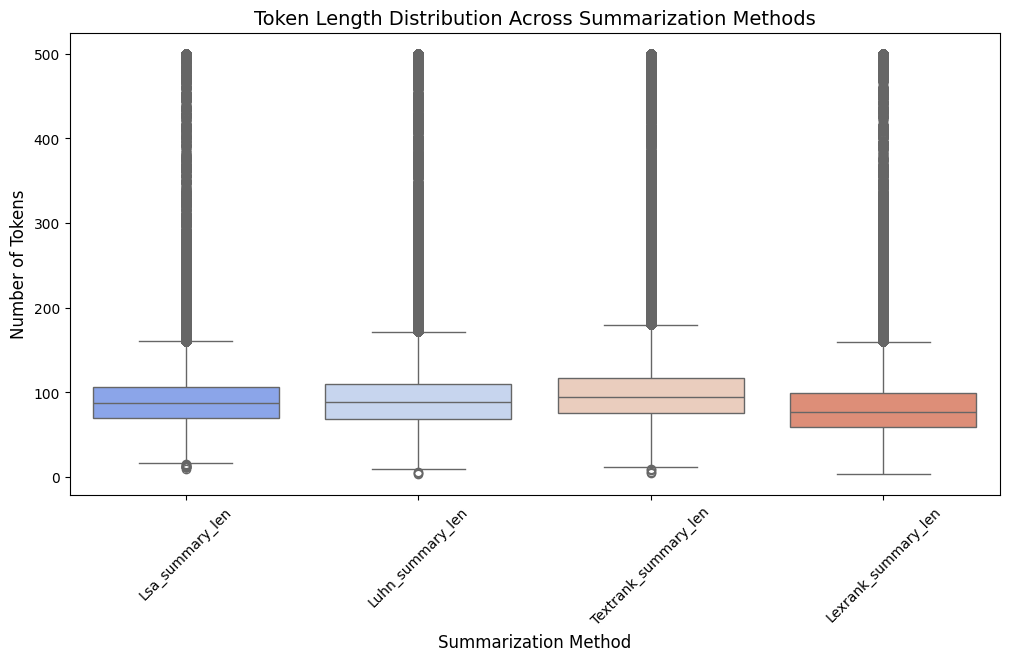

In [ ]:
df_melted1 = pd_df.melt(
    id_vars=["Date", "Article_title", "Stock_symbol", "Url", "Article_len"],
    value_vars=["Lsa_summary_len", "Luhn_summary_len", "Textrank_summary_len", "Lexrank_summary_len"],
    var_name="Summarization Method",
    value_name="Token Length"
)

# we've got some outliers...
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted1, x="Summarization Method", y="Token Length", palette="coolwarm")

plt.title("Token Length Distribution Across Summarization Methods", fontsize=14)
plt.xlabel("Summarization Method", fontsize=12)
plt.ylabel("Number of Tokens", fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [ ]:
pd_df = pd_df.sort_values(by='Lexrank_summary_len', ascending=False)
pd_df.tail(10)['Lexrank_summary'].sample(10).values

array(['Carey. Carey (NYSE: WPC).',
       'Lewis: No. Lewis: Oh, thank you. Lewis: Right.',
       'Crowe: Right. Crowe: Exactly.',
       "Muckerman: I don't know. O'Reilly: I don't know.",
       'All right. Brokamp: Right. Southwick: Yeah.',
       'CTRM)." But CTRM? CTRM Stock Weekly Price Chart',
       "O'Reilly: Oh, no. O'Reilly: Ever. O'Reilly: We shall see.",
       'Operator Thank you. Thank you. Thanks.',
       "O'Reilly: Oh, no. O'Reilly: Ever. O'Reilly: We shall see.",
       'What you need to know… The S&P 500 Index ('], dtype=object)

In [ ]:
# Extract day and month for plotting
pd_df['day'] = pd_df['Date'].dt.day
pd_df['month'] = pd_df['Date'].dt.month.astype('category')
pd_df['year'] = pd_df['Date'].dt.year

In [ ]:
df_count = pd_df.groupby("year").size().reset_index(name="count")

In [ ]:
fig = px.bar(df_count, x="year", y="count", title='Article Count per year')
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=df_count["year"])
    )
fig.show()

In [ ]:
df_spark.selectExpr("min(Date)").show()


+-------------------+
|          min(Date)|
+-------------------+
|2009-04-08 00:00:00|
+-------------------+



In [ ]:
def calendar(df, year):
    # Filter for the selected year
    df = df.loc[df['year'] == year]

    # Create a pivot table with days as columns and months as rows
    df_grouped = df.groupby(['month', 'day']).size().reset_index(name='count')

    # Correctly pivot the DataFrame
    df_pivot = df_grouped.pivot(index='month', columns='day', values='count').fillna(0)  # Fill NaN with 0 for missing dates

    # Create the heatmap
    plt.figure(figsize=(18, 12))  # Adjust figure size if needed
    sns.heatmap(df_pivot, annot=True, fmt="g", cmap="Blues", cbar_kws={'label': 'Article Count'},
                xticklabels=range(1, 32), yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                linewidths=0.5,
                vmin=0,
                vmax=8) # feel free to adjust this to change the threshold for what counts as a 'hole'

    # Customize the axes and title
    plt.title(f'{year} Article Heatmap')
    plt.xlabel('Day of Month')
    plt.ylabel('Month')

    # Show the plot
    plt.show()



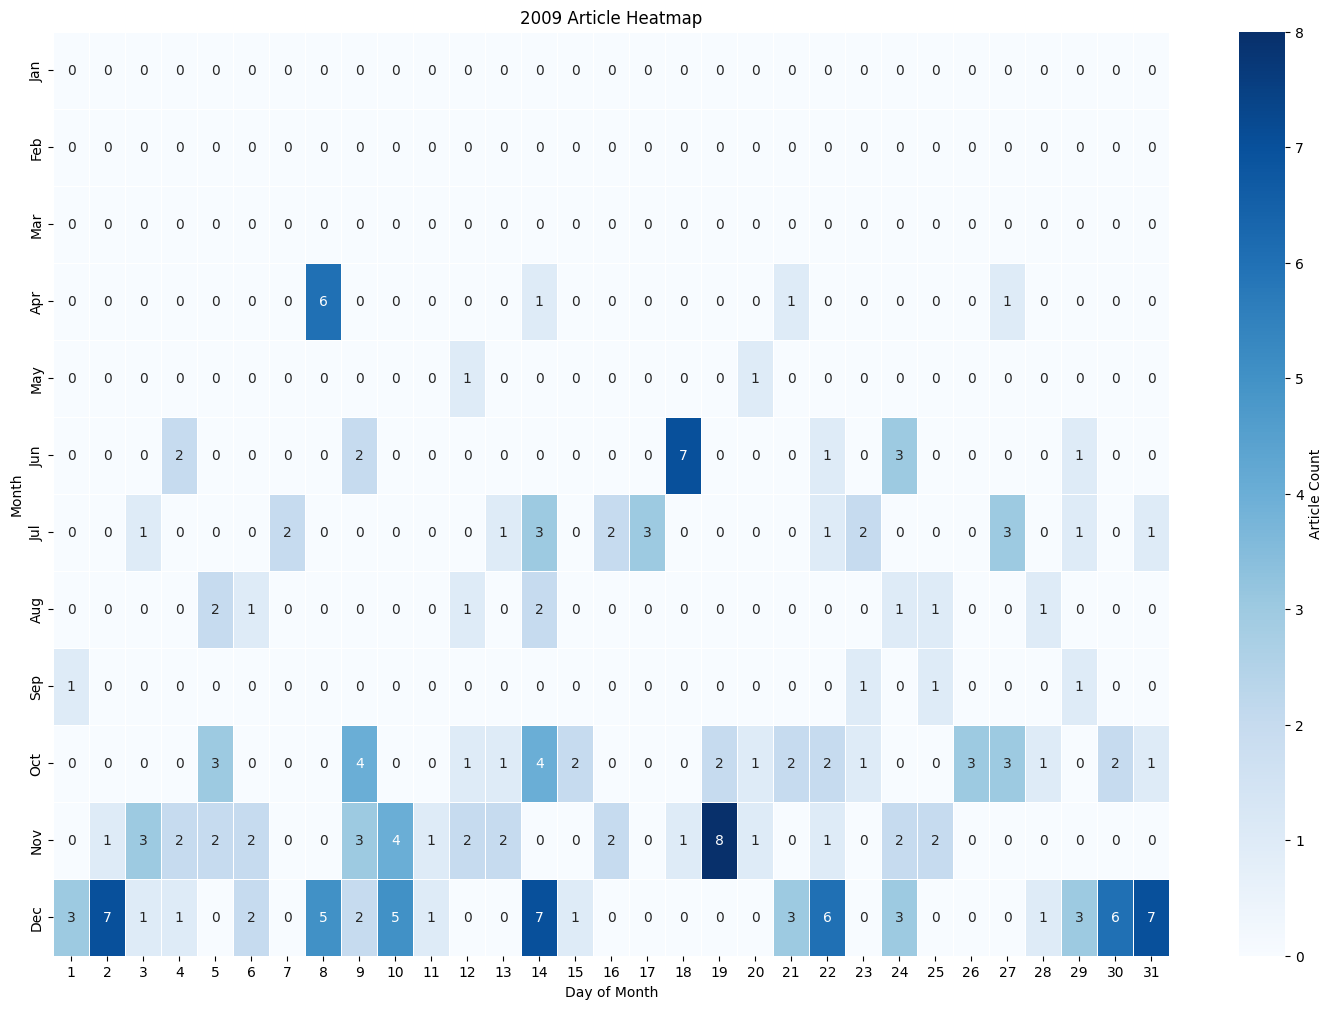

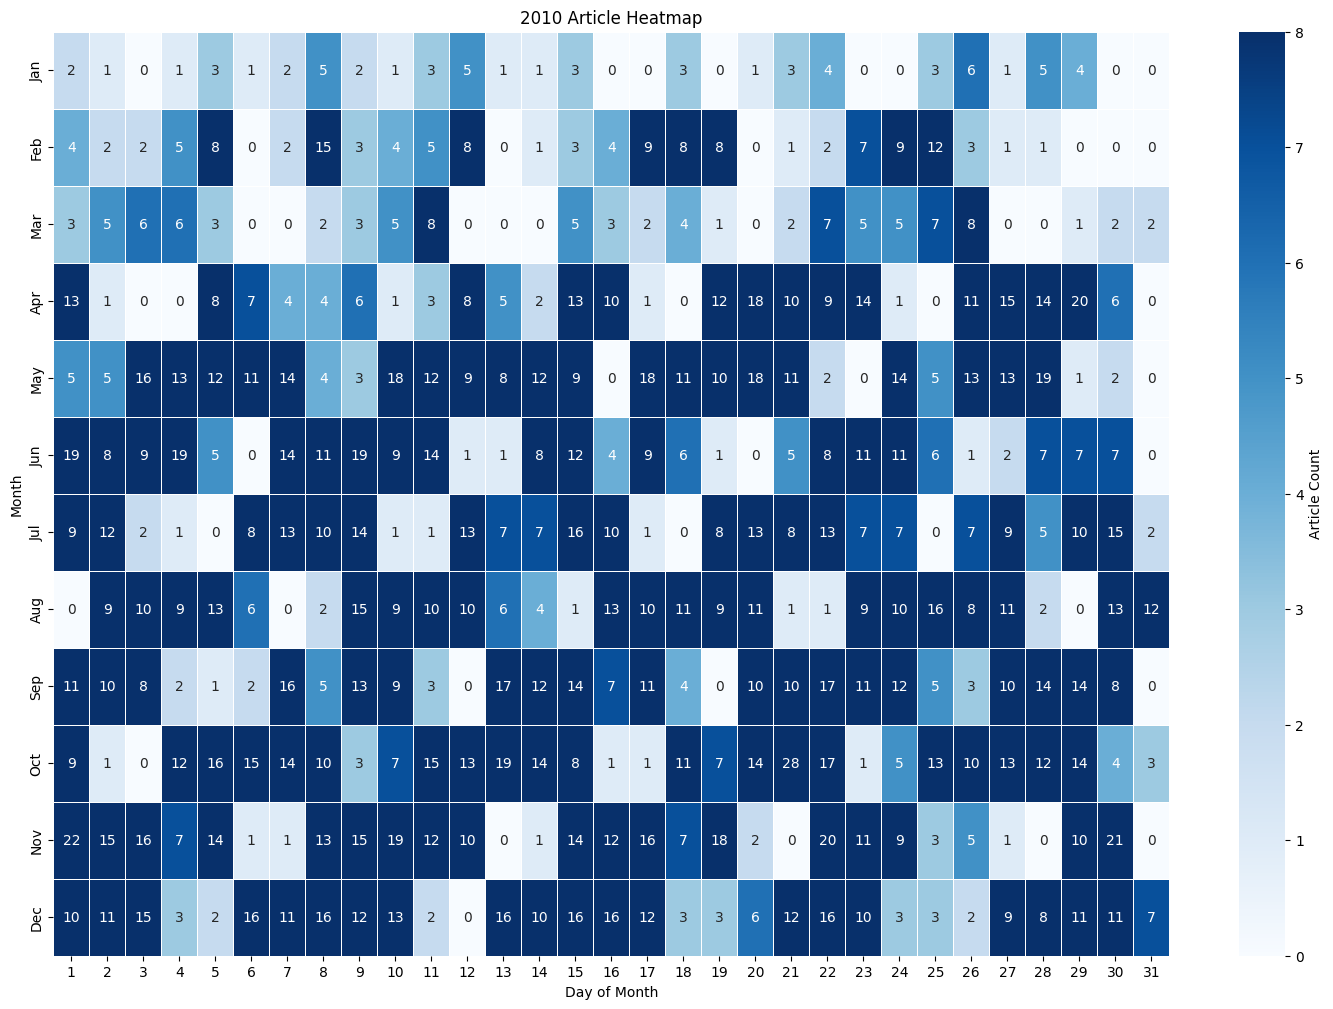

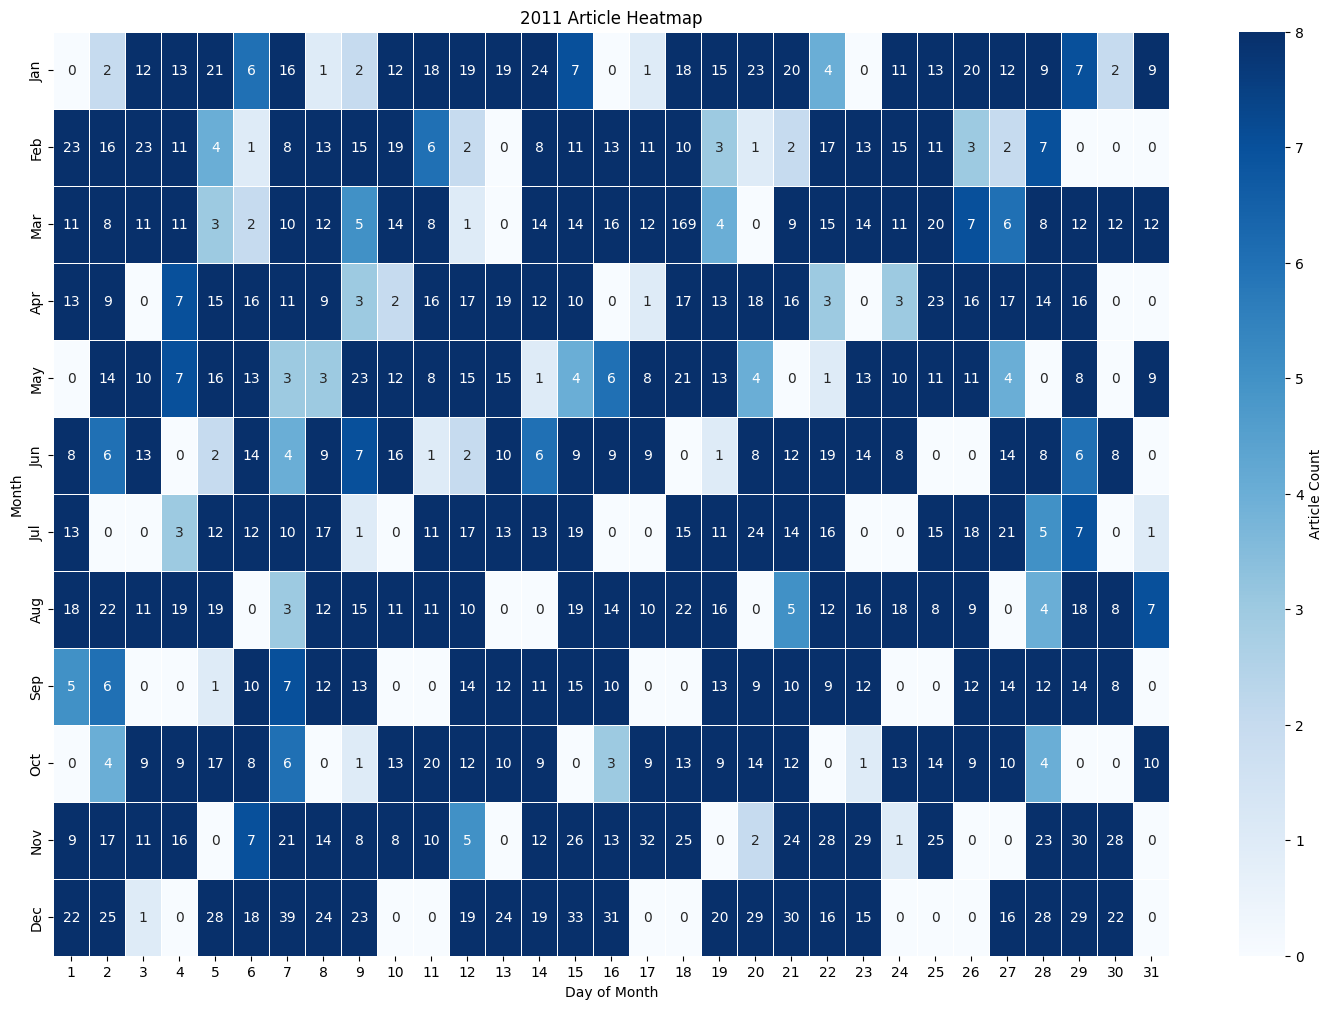

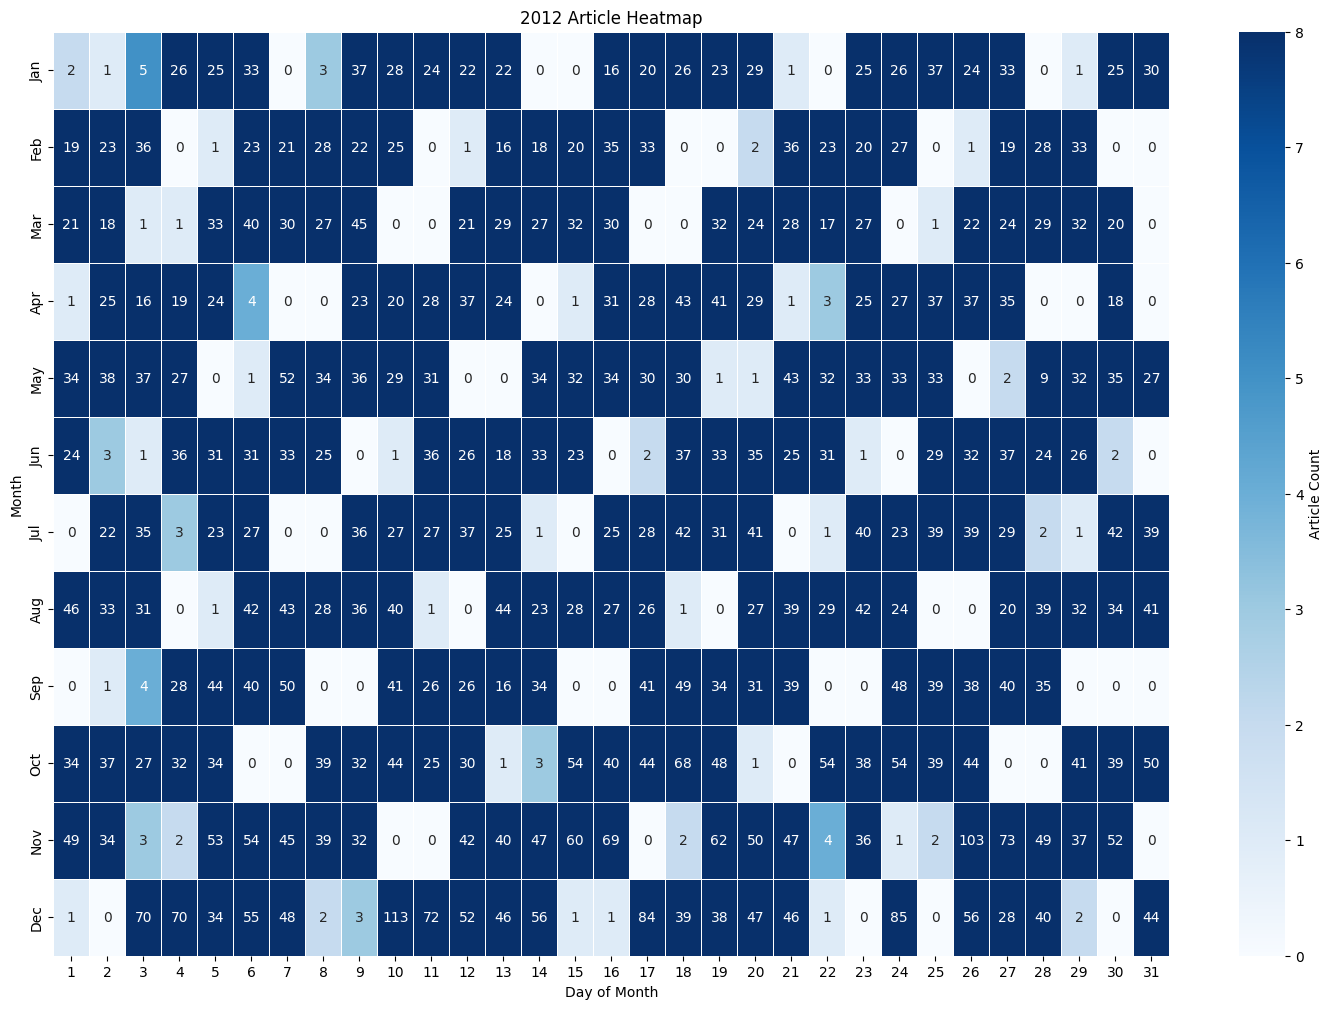

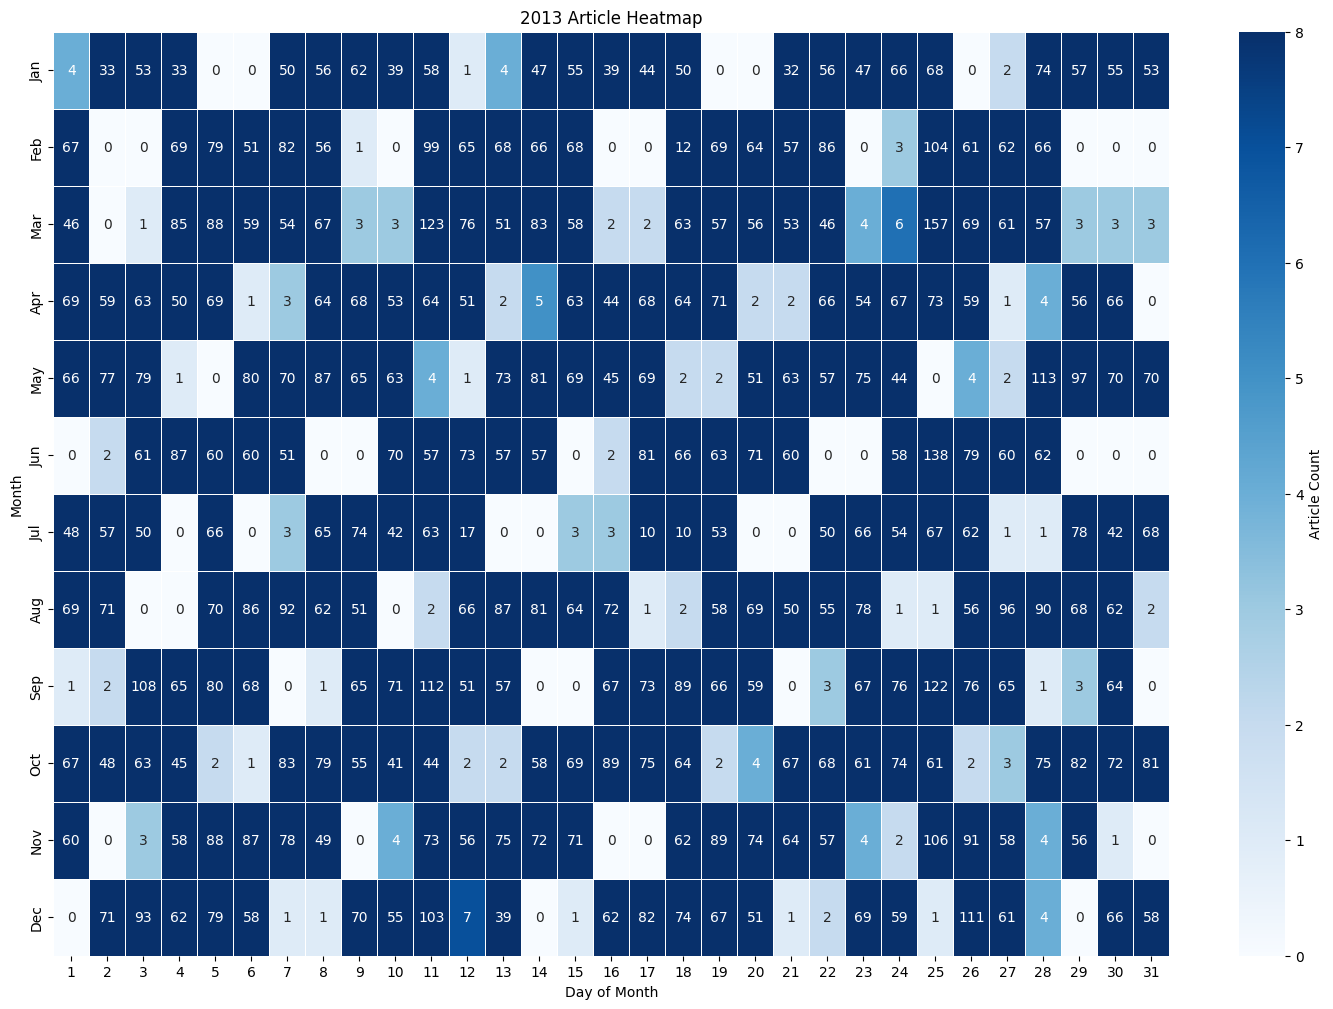

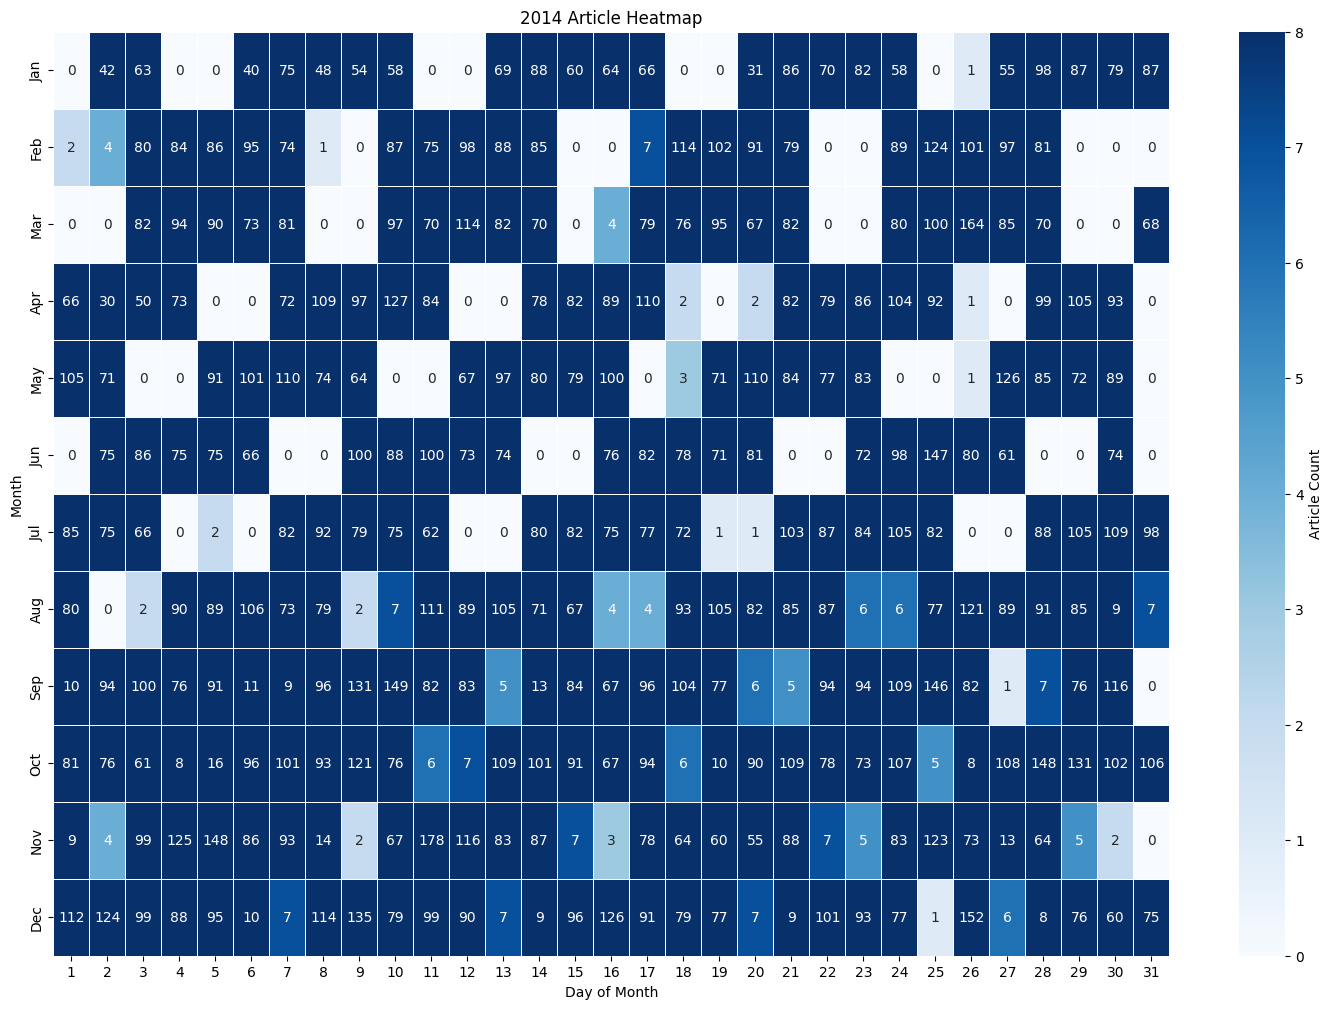

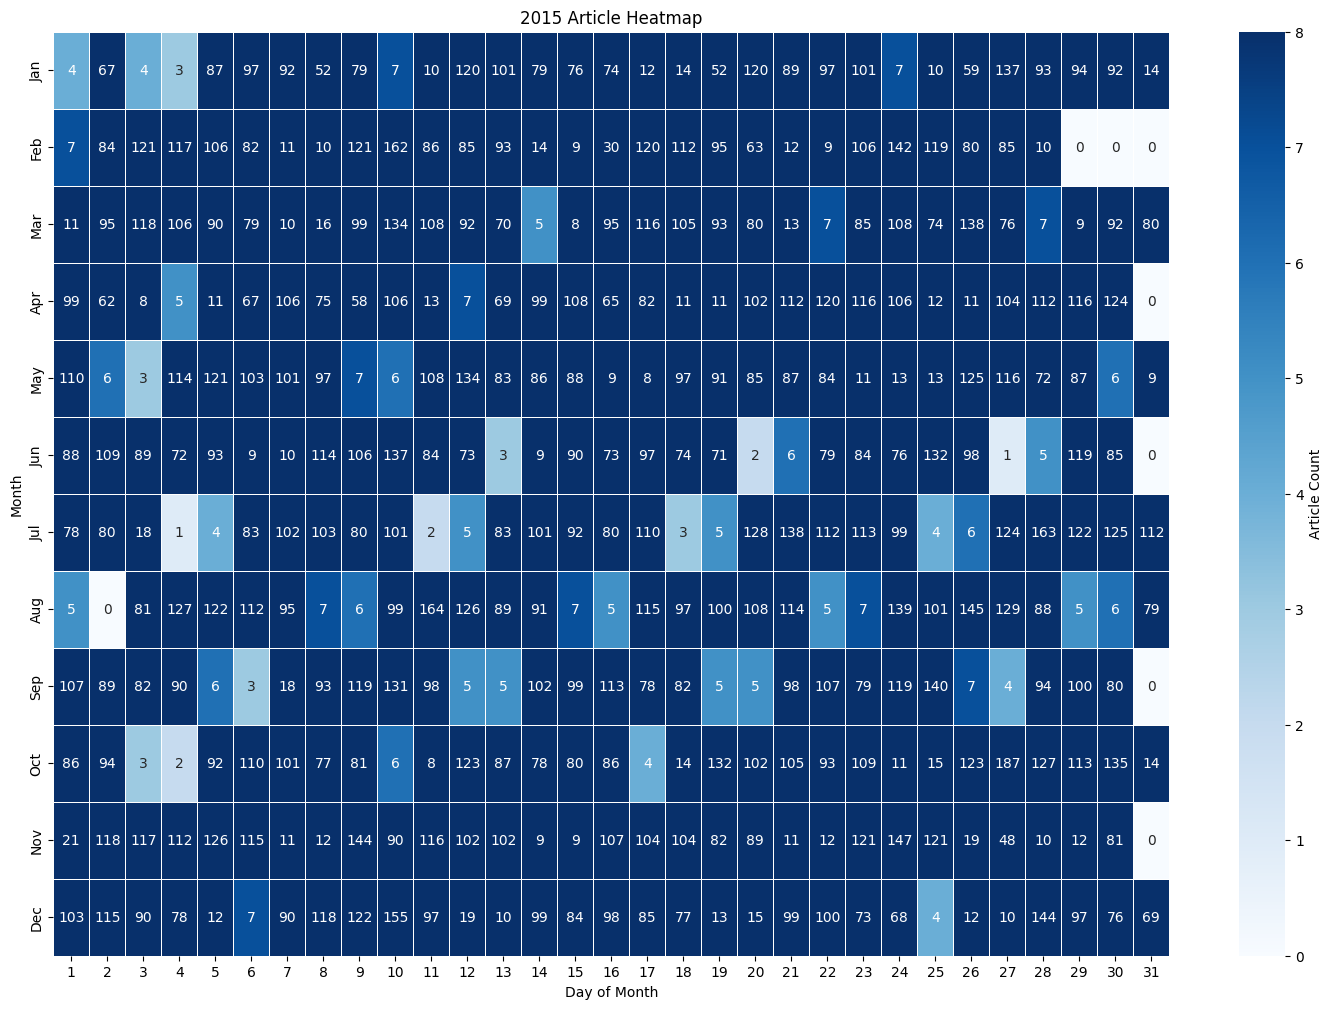

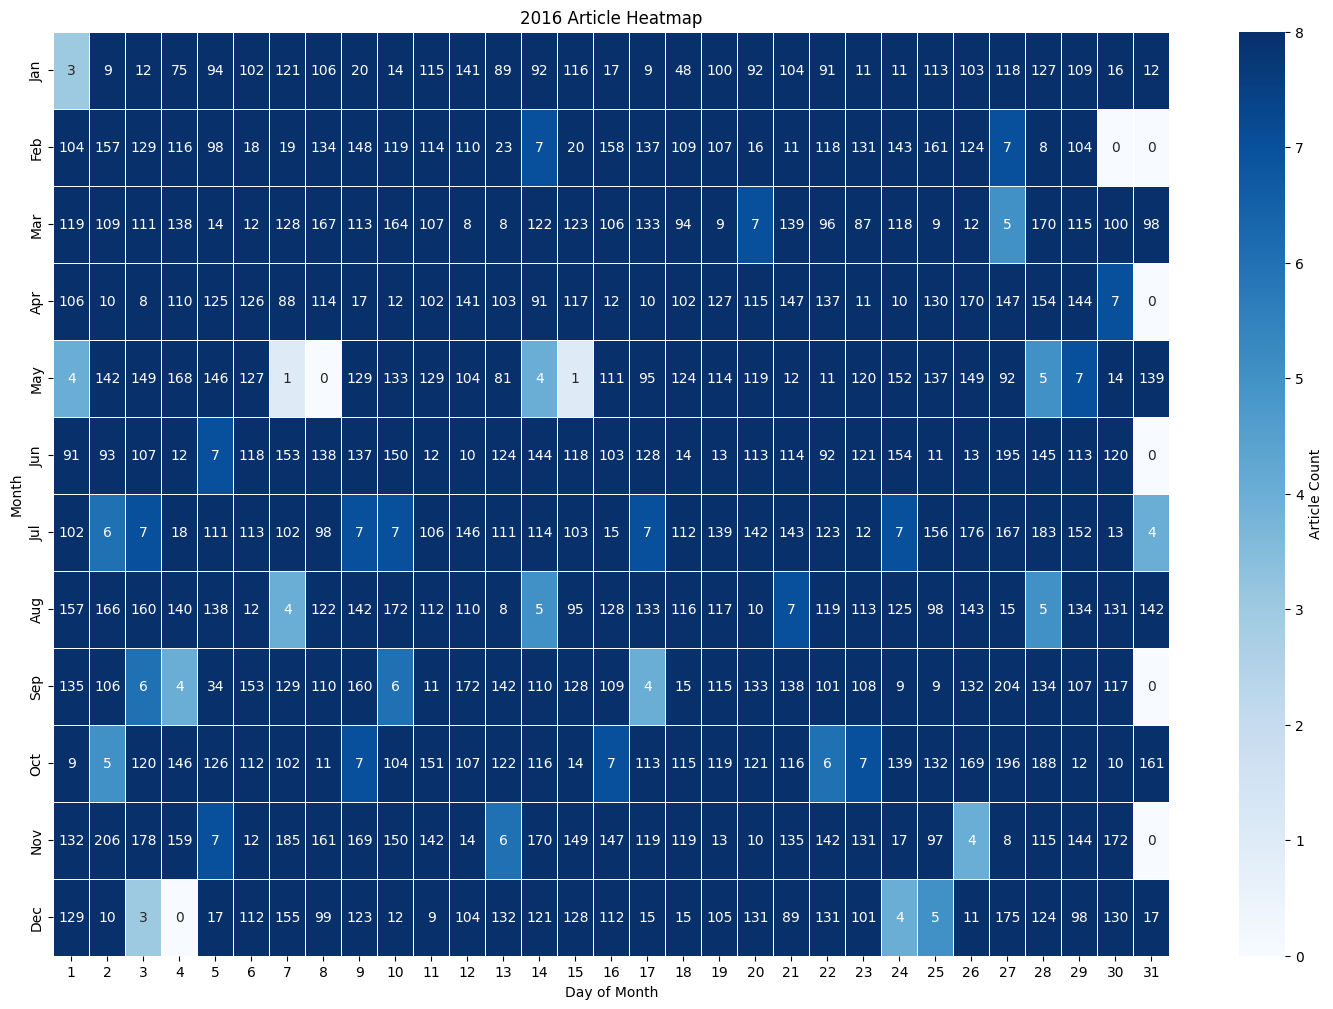

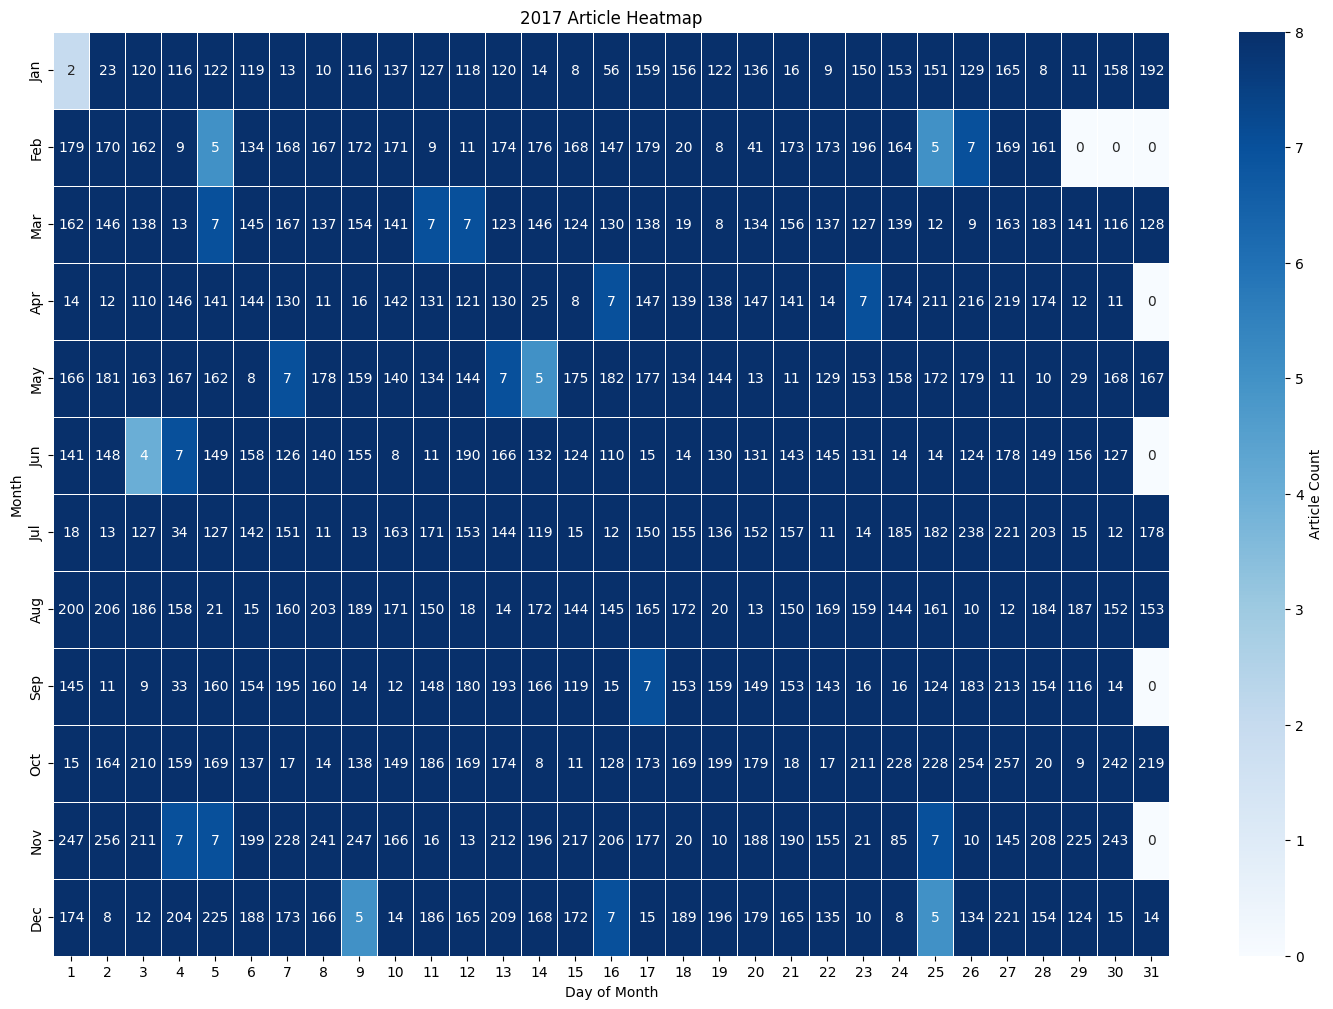

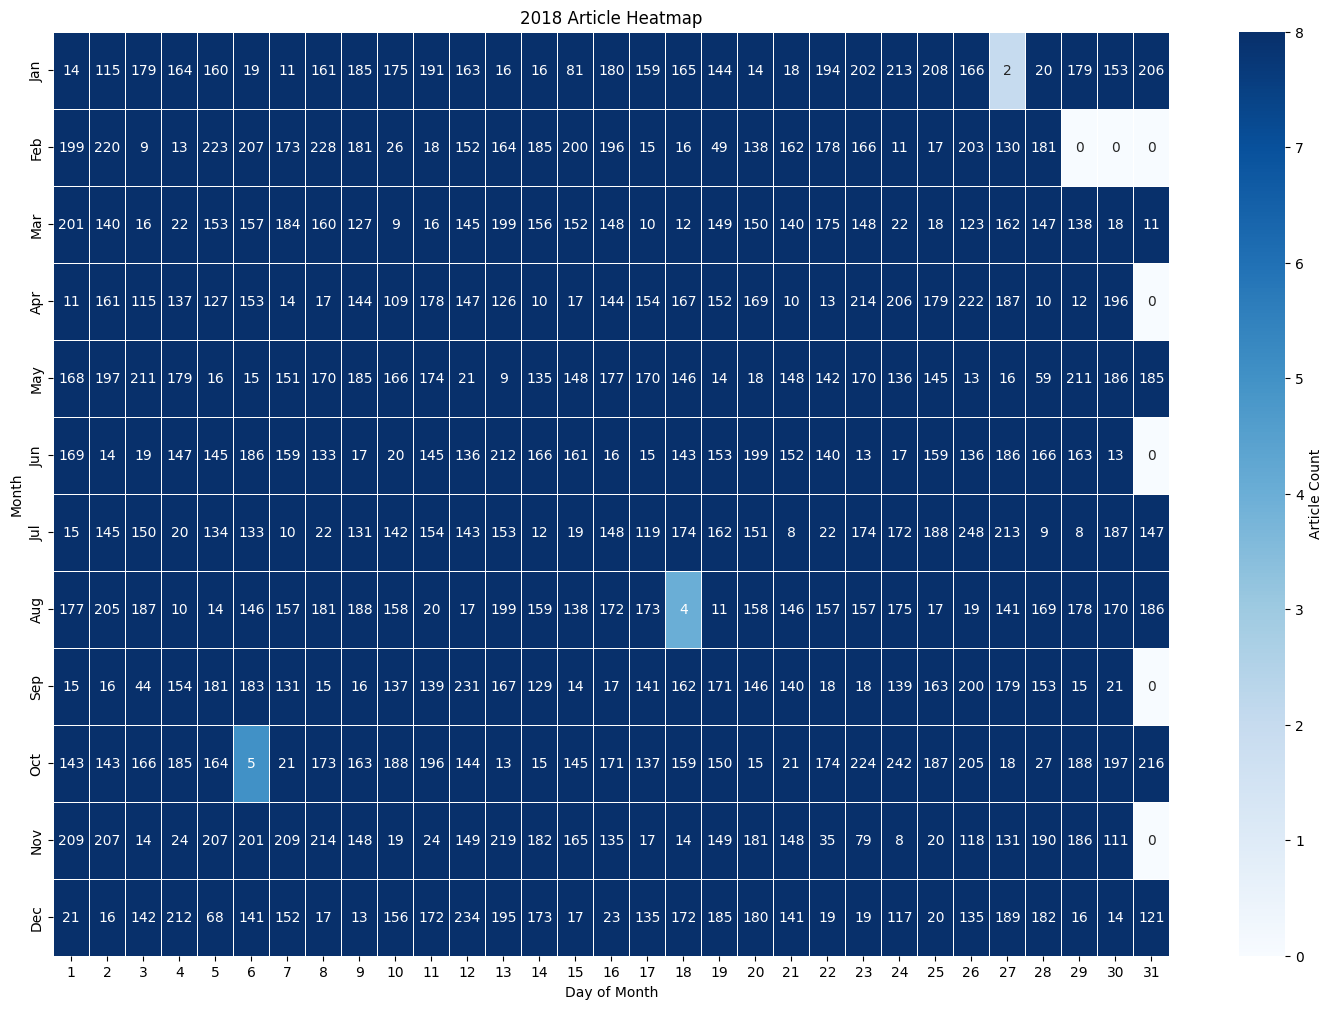

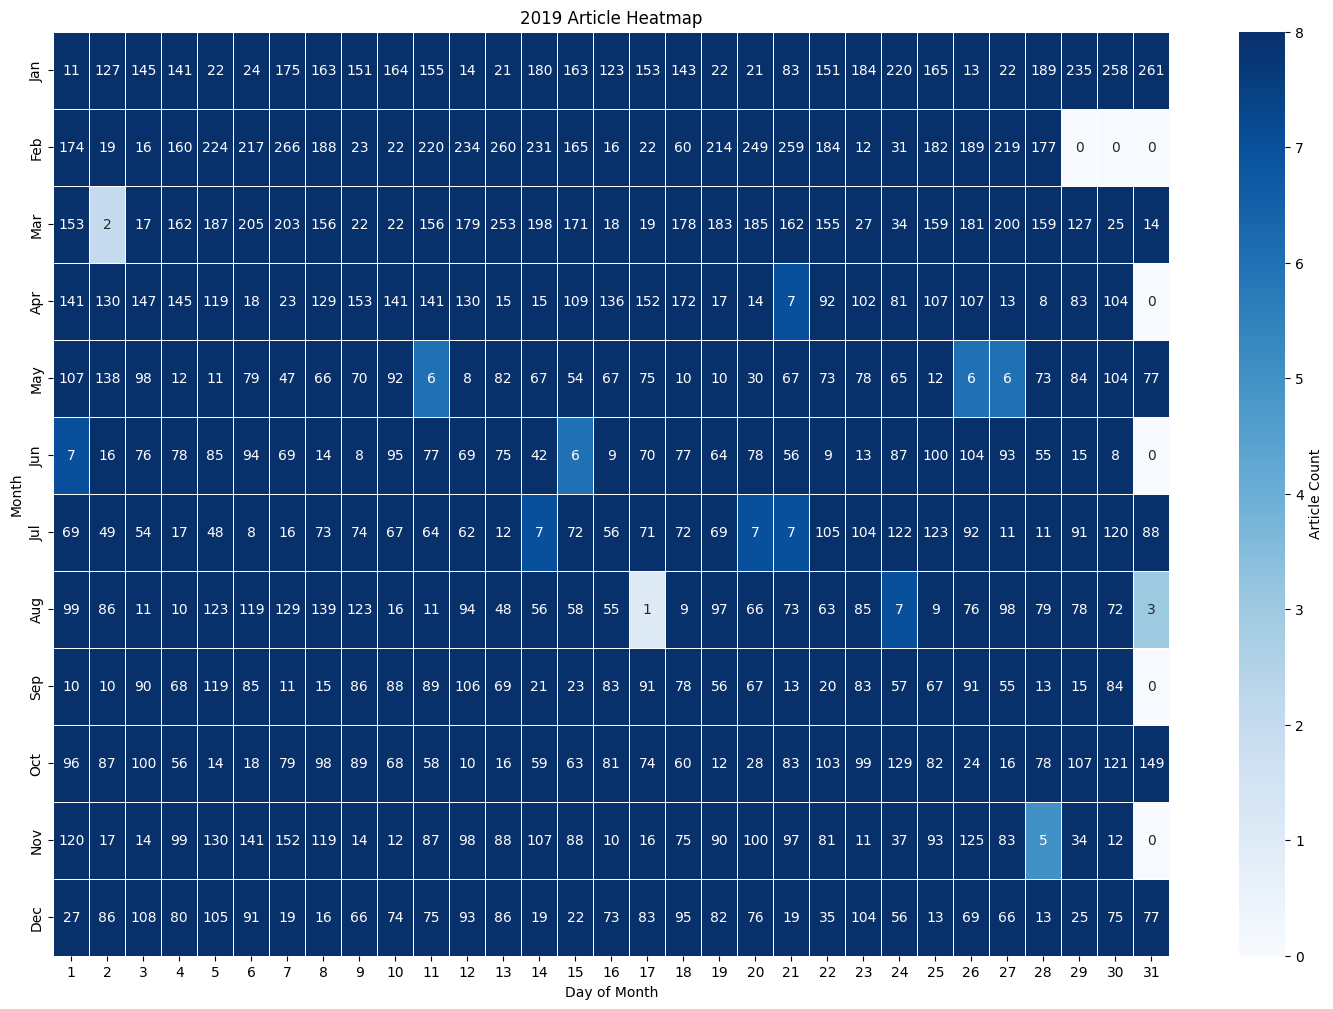

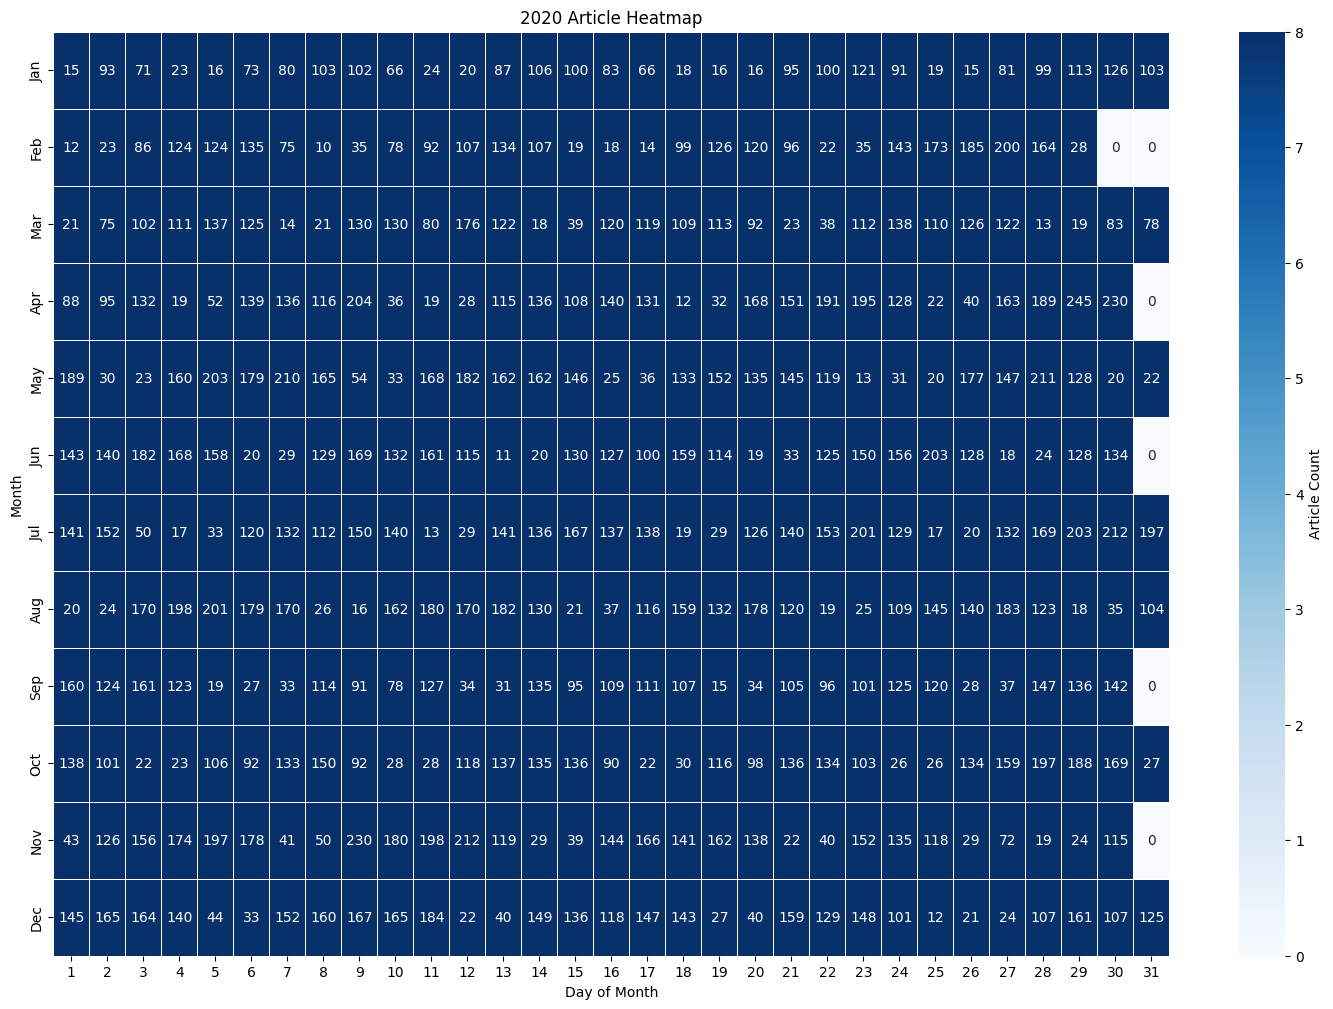

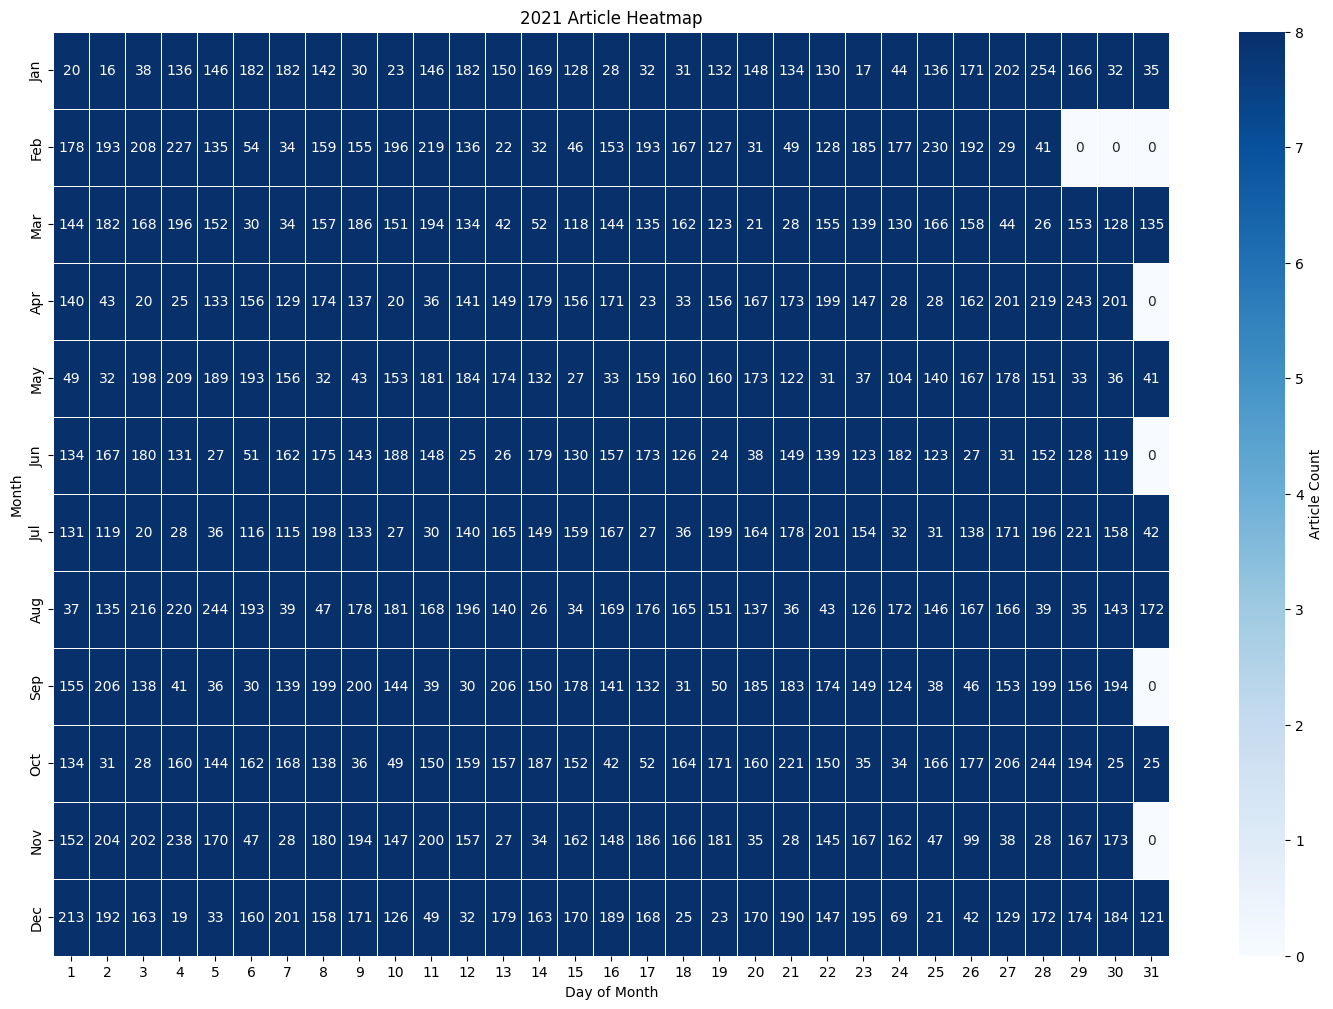

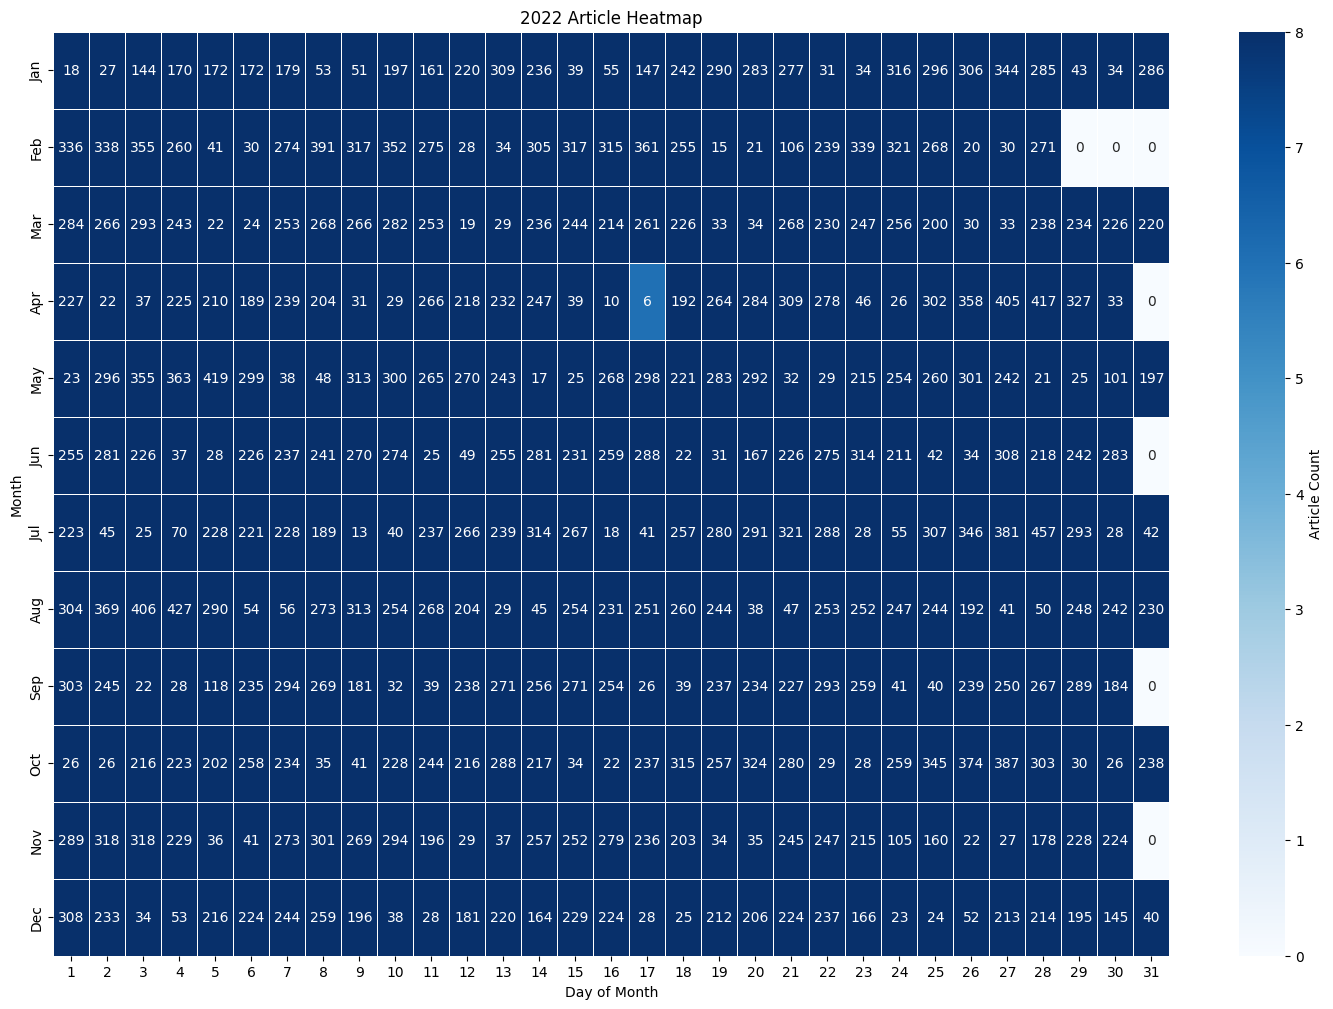

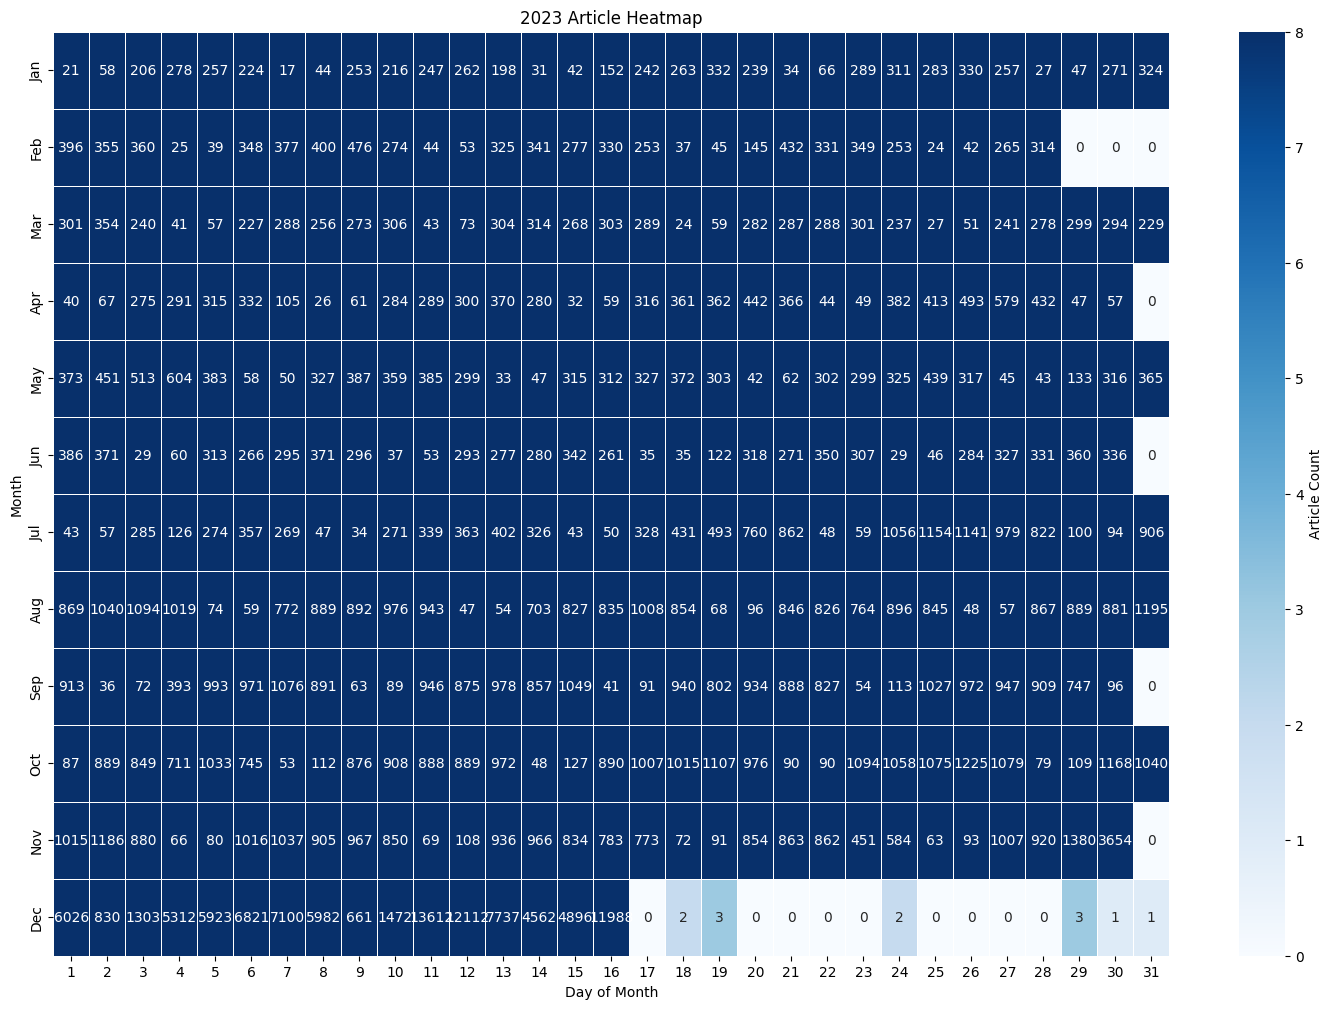

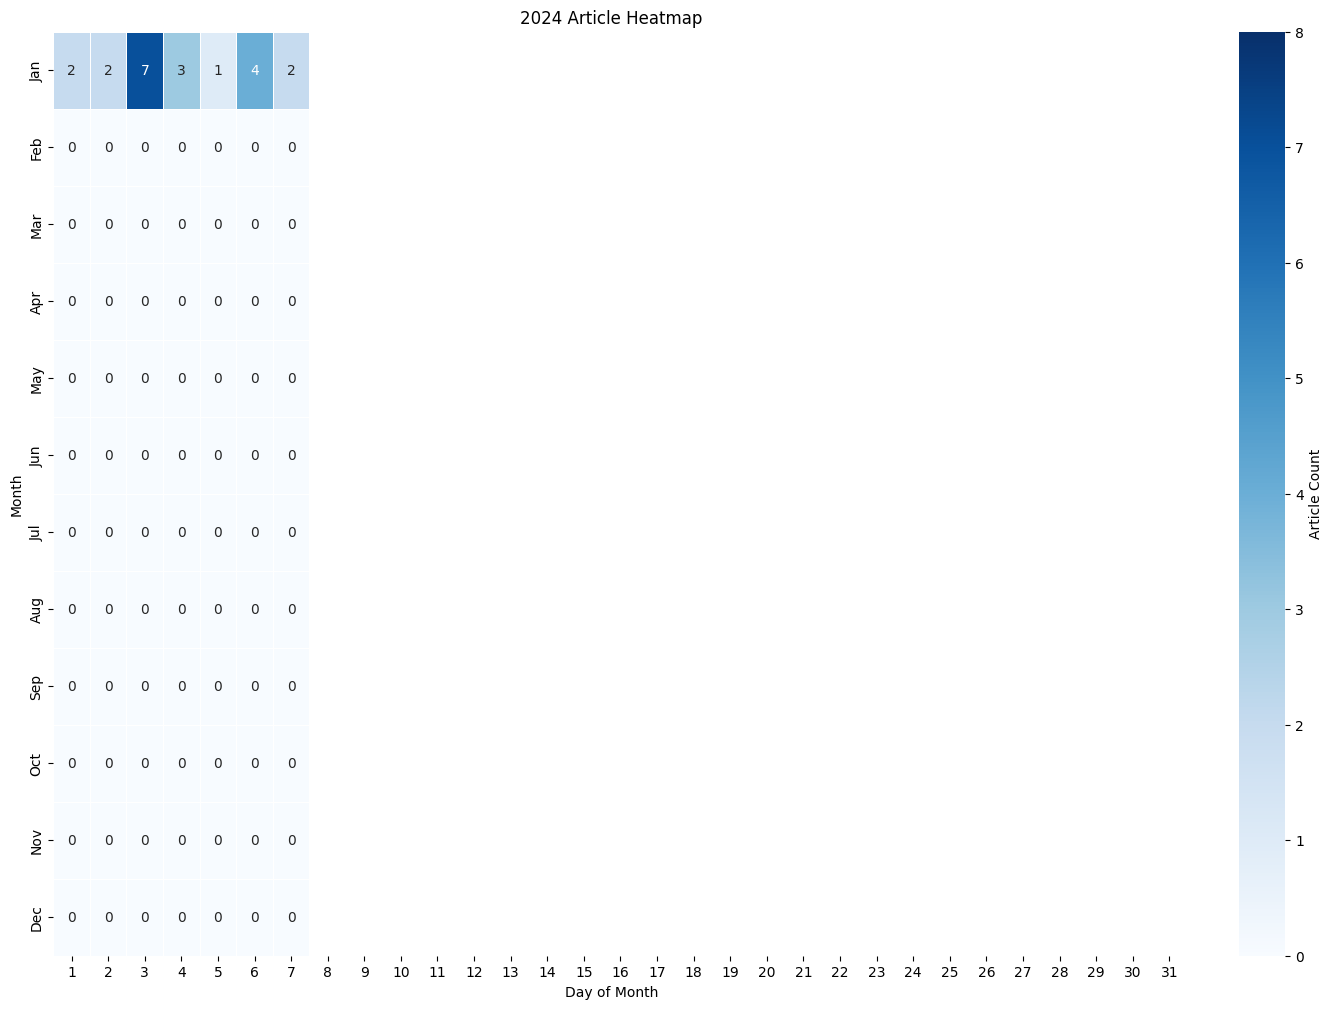

In [ ]:
years = sorted(pd_df['year'].unique())

for year in years:
    calendar(pd_df, year)

## Run FinBERT and return class probabilities for Positive, Neutral and Negative

In [ ]:
# Load FinBERT tokenizer & model (Optimized for financial sentiment analysis)
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)

print("✅ FinBERT Model Loaded on:", device)

✅ FinBERT Model Loaded on: cuda


In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, FloatType

# Define FinBERT sentiment function
def finbert_sentiment(text):
    try:
        if not text or text.strip() == "":  # Handle empty text cases
            return [0.0, 0.0, 0.0]  # Neutral probability for missing text

        # Tokenize and move to GPU
        inputs = tokenizer(text, truncation=True, padding=True, max_length=512, return_tensors="pt").to(device)

        # Get sentiment scores
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

        return probs.cpu().tolist()[0]  # Convert tensor to list

    except Exception as e:
        return [0.0, 0.0, 0.0]  # Default neutral probability in case of error

# Convert to PySpark UDF
finbert_udf = udf(finbert_sentiment, ArrayType(FloatType()))

# Apply FinBERT to `Lexrank_summary` and create probability columns
df_spark = df_spark.withColumn("FinBERT_Probs", finbert_udf(col("Lexrank_summary")))

# Extract individual sentiment scores
df_spark = df_spark.withColumn("Negative_Prob", col("FinBERT_Probs")[0])
df_spark = df_spark.withColumn("Neutral_Prob", col("FinBERT_Probs")[1])
df_spark = df_spark.withColumn("Positive_Prob", col("FinBERT_Probs")[2])

# Drop the combined probability array column
df_spark = df_spark.drop("FinBERT_Probs")

print("✅ FinBERT sentiment analysis applied successfully!")


✅ FinBERT sentiment analysis applied successfully!


In [ ]:
df_spark.limit(5).show()

+-------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+-----------+----+-------------+------------+-------------+
|               Date|       Article_title|Stock_symbol|                 Url|             Article|     Lexrank_summary|Lexrank_summary_len|Article_len|year|Negative_Prob|Neutral_Prob|Positive_Prob|
+-------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+-----------+----+-------------+------------+-------------+
|2023-12-16 23:00:00|Interesting A Put...|           A|https://www.nasda...|Investors in Agil...|At Stock Options ...|                138|        726|2023|     0.999972|2.6905587E-5|  1.060262E-6|
|2023-12-12 00:00:00|Wolfe Research In...|           A|https://www.nasda...|Fintel reports th...|The projected ann...|                 36|        773|2023|  7.456383E-5|   0.9999254| 1.1026489E-7|
|2023-12-12 00:

In [ ]:
!free -h  # Check RAM
!nvidia-smi  # Check GPU
!df -h  # Check disk space


               total        used        free      shared  buff/cache   available
Mem:            83Gi        42Gi       7.6Gi       142Mi        33Gi        39Gi
Swap:             0B          0B          0B
Mon Feb 10 03:33:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0        

# Running FinBERT on the NYT Dataset
**(Already done; no need to run)**

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import drive, files
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
drive.mount('/content/drive', force_remount=True)

!pip install -q transformers torch tqdm




In [5]:
# @title
NYT = pd.read_csv("/content/drive/My Drive/nyt_full.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/nyt_full.csv'

In [ ]:
# @title
NYT.head()

In [ ]:
# @title
NYT["abstract_len"] = NYT["abstract"].str.split().str.len()  # Calculate summary length


In [ ]:
# @title
NYT['abstract'].sample(2).values[0]

In [ ]:
# @title
NYT.columns

In [ ]:
# @title

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)

print(f"✅ FinBERT Model Loaded on: {device}")

# 5️⃣ Define Function to Run Sentiment Analysis
def finbert_sentiment(text):
    """Runs FinBERT on text and returns sentiment probabilities."""
    try:
        if not text or text.strip() == "":
            return [0.0, 0.0, 0.0]  # Default to neutral if text is missing

        inputs = tokenizer(text, truncation=True, padding=True, max_length=512, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().tolist()[0]
        return probs
    except Exception as e:
        return [0.0, 0.0, 0.0]  # Return neutral in case of error

# 6️⃣ Apply FinBERT Sentiment Analysis (with Progress Bar)
tqdm.pandas()
NYT[["Negative_Prob", "Neutral_Prob", "Positive_Prob"]] = NYT["abstract"].progress_apply(lambda x: pd.Series(finbert_sentiment(x)))

print("✅ FinBERT Sentiment Analysis Completed!")

# 7️⃣ Save the Processed Data
NYT.to_parquet("/content/drive/My Drive/nyt_FinBERT_Results.parquet", index=False)


# FNSPID EDA

In [ ]:
# @title
df = pd.read_parquet("/content/drive/My Drive/w210/Optimizing Investment Portfolio Capstone/data-text/FNSPID/FNSPID_FinBERT_Results.parquet")

In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sentiment_trends(df, ticker, window=30):
    """
    Fixes duplicate dates by averaging daily sentiment scores.
    - Uses rolling averages to smooth fluctuations.
    - Ensures all sentiment trends are clear and non-overlapping.
    """
    stock = df[df["Stock_symbol"] == ticker].copy()
    stock["Date"] = pd.to_datetime(stock["Date"])

    stock = stock.groupby("Date")[["Positive_Prob", "Neutral_Prob", "Negative_Prob"]].mean()

    stock["Positive_Rolling"] = stock["Positive_Prob"].rolling(window=window, min_periods=1).mean()
    stock["Neutral_Rolling"] = stock["Neutral_Prob"].rolling(window=window, min_periods=1).mean()
    stock["Negative_Rolling"] = stock["Negative_Prob"].rolling(window=window, min_periods=1).mean()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=stock, x=stock.index, y="Positive_Rolling", color="green", label="Positive")
    sns.lineplot(data=stock, x=stock.index, y="Neutral_Rolling", color="gray", label="Neutral")
    sns.lineplot(data=stock, x=stock.index, y="Negative_Rolling", color="red", label="Negative")

    plt.title(f"Smoothed Sentiment Trends for {ticker} ({window}-Day Moving Avg)")
    plt.ylabel("Sentiment Probability")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Example Usage
plot_sentiment_trends(df, "TSLA", window=14)


In [ ]:
# @title
plt.figure(figsize=(10, 5))
sns.violinplot(data=df[['Positive_Prob', 'Neutral_Prob', 'Negative_Prob']])
plt.title("Distribution of Sentiment Probabilities")
plt.show()


In [ ]:
# @title
def plot_sentiment_distribution(df, window=30):
    """
    Creates a stacked area chart showing sentiment distribution over time.
    - Aggregates by date and normalizes so each day sums to 100%.
    - Uses a rolling average to smooth fluctuations.
    """
    df["Date"] = pd.to_datetime(df["Date"])

    sentiment_trend = df.groupby("Date")[["Positive_Prob", "Neutral_Prob", "Negative_Prob"]].mean()

    sentiment_trend["Total"] = sentiment_trend.sum(axis=1)
    sentiment_trend["Positive_Prob"] = (sentiment_trend["Positive_Prob"] / sentiment_trend["Total"]) * 100
    sentiment_trend["Neutral_Prob"] = (sentiment_trend["Neutral_Prob"] / sentiment_trend["Total"]) * 100
    sentiment_trend["Negative_Prob"] = (sentiment_trend["Negative_Prob"] / sentiment_trend["Total"]) * 100
    sentiment_trend.drop(columns=["Total"], inplace=True)

    sentiment_trend = sentiment_trend.rolling(window=window, min_periods=1).mean()

    plt.figure(figsize=(12, 6))
    plt.stackplot(
        sentiment_trend.index,
        sentiment_trend["Positive_Prob"],
        sentiment_trend["Neutral_Prob"],
        sentiment_trend["Negative_Prob"],
        labels=["Positive", "Neutral", "Negative"],
        colors=["green", "gray", "red"],
        alpha=0.7
    )

    plt.title(f"Sentiment Distribution Over Time ({window}-Day Rolling Average)")
    plt.ylabel("Sentiment Proportion (%)")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.legend(loc="upper right")
    plt.show()

plot_sentiment_distribution(df, window=7)


In [ ]:
# @title
def plot_yearly_sentiment(df):
    """Plots a grouped bar chart of yearly sentiment proportions."""
    df["Year"] = df["Date"].dt.year
    yearly_sentiment = df.groupby("Year")[["Positive_Prob", "Neutral_Prob", "Negative_Prob"]].mean()

    # Normalize to sum to 100%
    yearly_sentiment = yearly_sentiment.div(yearly_sentiment.sum(axis=1), axis=0) * 100

    yearly_sentiment.plot(kind="bar", stacked=True, figsize=(12, 6), color=["green", "gray", "red"])
    plt.title("Sentiment Proportion by Year")
    plt.ylabel("Sentiment Percentage (%)")
    plt.xlabel("Year")
    plt.legend(["Positive", "Neutral", "Negative"], loc="upper right")
    plt.show()

plot_yearly_sentiment(df)


In [ ]:
# @title
def plot_sentiment_volatility(df, window=30):
    """Plots rolling standard deviation of sentiment to show volatility over time."""
    df["Date"] = pd.to_datetime(df["Date"])
    sentiment_volatility = df.groupby("Date")[["Positive_Prob", "Neutral_Prob", "Negative_Prob"]].std()

    # Apply rolling average for smoothing
    sentiment_volatility = sentiment_volatility.rolling(window=window, min_periods=1).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(sentiment_volatility.index, sentiment_volatility["Positive_Prob"], color="green", label="Positive Volatility")
    plt.plot(sentiment_volatility.index, sentiment_volatility["Neutral_Prob"], color="gray", label="Neutral Volatility")
    plt.plot(sentiment_volatility.index, sentiment_volatility["Negative_Prob"], color="red", label="Negative Volatility")

    plt.title(f"Sentiment Volatility Over Time ({window}-Day Rolling Average)")
    plt.ylabel("Rolling Standard Deviation")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sentiment_volatility(df, window=30)


# Merging FNSPID and NYT

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import drive, files
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
drive.mount('/content/drive', force_remount=True)

FNSPID = pd.read_parquet("/content/drive/My Drive/FNSPID_FinBERT_Results.parquet")
NYT = pd.read_parquet("/content/drive/My Drive/nyt_FinBERT_Results_filtered20240211.parquet")

In [ ]:
FNSPID_len = len(FNSPID)
NYT_len = len(NYT)
print(f"FNSPID Length: {'{:,.0f}'.format(FNSPID_len)}")
print(f"NYT Length: {'{:,.0f}'.format(NYT_len)}")
print(f"Total Length: {'{:,.0f}'.format(FNSPID_len+NYT_len)}")

In [ ]:
# check time stamps on both datasets
FNSPID['Date'].head(2)

In [ ]:
NYT['pub_date'].head(2)

In [ ]:
# clean dtyle and make timezone agnostic
NYT['pub_date'] = pd.to_datetime(NYT['pub_date'])
NYT['pub_date'] = NYT['pub_date'].dt.tz_localize(None)

# Extract date
FNSPID['Date'] = FNSPID['Date'].dt.date
NYT['pub_date'] = NYT['pub_date'].dt.date

In [ ]:
NYT.columns

In [ ]:
# Creating uniform naming for both datasets before doing pd.concat
NYT = NYT.rename(columns={'pub_date': 'Date', 'abstract':'Summary'})
NYT.columns = NYT.columns.str.title()
NYT = NYT[['Date', 'Summary','Ticker', 'Positive_Prob', 'Neutral_Prob', 'Negative_Prob']]
NYT

In [ ]:
FNSPID = FNSPID.rename(columns={'Stock_symbol': 'Ticker', 'Lexrank_summary':'Summary'})
FNSPID.columns = FNSPID.columns.str.title()
FNSPID = FNSPID[['Date','Summary','Ticker','Positive_Prob', 'Neutral_Prob', 'Negative_Prob']]
FNSPID

In [ ]:
df = pd.concat([FNSPID, NYT], axis=0, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
len(df)

In [ ]:
import pandas as pd
import plotly.express as px

# Extract the year from the Date column
df["Year"] = pd.to_datetime(df["Date"]).dt.year

# Count articles per year
df_yearly_counts = df.groupby("Year").size().reset_index(name="Count")

fig = px.bar(
    df_yearly_counts,
    x="Year",
    y="Count",
    title=f"Article Count per Year (Log Scale) Combining FNSPID and NYT (2.7M rows)",
    labels={"Count": "Article Count", "Year": "Year"},
    log_y=True
)

fig.show()


In [ ]:
df.sample(4)

In [ ]:
df.dtypes

In [ ]:
# Extract day and month for plotting
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month.astype('category')
df['Year'] = df['Date'].dt.year

In [ ]:
def calendar(df, year):
    # Filter for the selected year
    df = df.loc[df['Year'] == year]

    # Create a pivot table with days as columns and months as rows
    df_grouped = df.groupby(['Month', 'Day']).size().reset_index(name='count')

    # Correctly pivot the DataFrame
    df_pivot = df_grouped.pivot(index='Month', columns='Day', values='count').fillna(0)  # Fill NaN with 0 for missing dates

    # Create the heatmap
    plt.figure(figsize=(18, 12))  # Adjust figure size if needed
    sns.heatmap(df_pivot, annot=True, fmt="g", cmap="Blues", cbar_kws={'label': 'Article Count'},
                xticklabels=range(1, 32), yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                linewidths=0.5,
                vmin=0,
                vmax=8) # feel free to adjust this to change the threshold for what counts as a 'hole'

    # Customize the axes and title
    plt.title(f'{year} Article Heatmap')
    plt.xlabel('Day of Month')
    plt.ylabel('Month')

    # Show the plot
    plt.show()


years = sorted(df['Year'].unique())

for year in years:
    calendar(df, year)

In [ ]:
def plot_sentiment_distribution(df, window=30):
    """
    Creates a stacked area chart showing sentiment distribution over time.
    - Aggregates by date and normalizes so each day sums to 100%.
    - Uses a rolling average to smooth fluctuations.
    """
    df["Date"] = pd.to_datetime(df["Date"])

    sentiment_trend = df.groupby("Date")[["Positive_Prob", "Neutral_Prob", "Negative_Prob"]].mean()

    sentiment_trend["Total"] = sentiment_trend.sum(axis=1)
    sentiment_trend["Positive_Prob"] = (sentiment_trend["Positive_Prob"] / sentiment_trend["Total"]) * 100
    sentiment_trend["Neutral_Prob"] = (sentiment_trend["Neutral_Prob"] / sentiment_trend["Total"]) * 100
    sentiment_trend["Negative_Prob"] = (sentiment_trend["Negative_Prob"] / sentiment_trend["Total"]) * 100
    sentiment_trend.drop(columns=["Total"], inplace=True)

    sentiment_trend = sentiment_trend.rolling(window=window, min_periods=1).mean()

    plt.figure(figsize=(12, 6))
    plt.stackplot(
        sentiment_trend.index,
        sentiment_trend["Positive_Prob"],
        sentiment_trend["Neutral_Prob"],
        sentiment_trend["Negative_Prob"],
        labels=["Positive", "Neutral", "Negative"],
        colors=["green", "gray", "red"],
        alpha=0.7
    )

    plt.title(f"Sentiment Distribution Over Time ({window}-Day Rolling Average)")
    plt.ylabel("Sentiment Proportion (%)")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.legend(loc="upper right")
    plt.show()

plot_sentiment_distribution(df, window=7)


# Reading in Combined NYT x FNSPID Dataset
- Combining SP500 returns
- EDA on sentiment x market returns

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import drive, files
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
drive.mount('/content/drive', force_remount=True)

import os

#file_path = "/content/drive/My Drive/w210/Optimizing_Investment_Portfolio_Capstone/data-text/FNSPID/"

# Check if the directory exists
#print("Directory exists:", os.path.isdir(os.path.dirname(file_path)))

# Check if the file exists
#print("File exists:", os.path.isfile(file_path))

# List files in the directory
#print("Files in directory:", os.listdir(os.path.dirname(file_path)))

df = pd.read_parquet("/content/drive/My Drive/w210/Optimizing Investment Portfolio Capstone/data-text/FNSPID/FNSPID_NYT_Combined_Dataset_021125.parquet")
market = pd.read_pickle("/content/drive/My Drive/w210/Optimizing Investment Portfolio Capstone/data-nn/mkt_daily.pkl")

Mounted at /content/drive


In [3]:
df = df.groupby('Date').agg({'Positive_Prob': 'mean', 'Neutral_Prob': 'mean', 'Negative_Prob': 'mean'})

In [4]:
# Lagging return_sp by one day so sentiment scores predict the next day's return
market["return_sp_lag"] = market["return_sp"].shift(1)
df = df.merge(market[['return_sp_lag']], left_on='Date', right_on=market.index, how='left')


In [5]:
rolling_windows = [3, 7, 14, 30]

# Creating rolling averages
for window in rolling_windows:
    df[f"Positive_Prob_{window}d_avg"] = df["Positive_Prob"].rolling(window=window, min_periods=1).mean()
    df[f"Neutral_Prob_{window}d_avg"] = df["Neutral_Prob"].rolling(window=window, min_periods=1).mean()
    df[f"Negative_Prob_{window}d_avg"] = df["Negative_Prob"].rolling(window=window, min_periods=1).mean()

# Creating lagged features
lags = [1, 3, 5, 10, 14]
for lag in lags:
    df[f"Positive_Prob_lag{lag}"] = df["Positive_Prob"].shift(lag)
    df[f"Neutral_Prob_lag{lag}"] = df["Neutral_Prob"].shift(lag)
    df[f"Negative_Prob_lag{lag}"] = df["Negative_Prob"].shift(lag)

In [6]:
df

,Date,Positive_Prob,Neutral_Prob,Negative_Prob,return_sp_lag,Positive_Prob_3d_avg,Neutral_Prob_3d_avg,Negative_Prob_3d_avg,Positive_Prob_7d_avg,Neutral_Prob_7d_avg,...,Negative_Prob_lag3,Positive_Prob_lag5,Neutral_Prob_lag5,Negative_Prob_lag5,Positive_Prob_lag10,Neutral_Prob_lag10,Negative_Prob_lag10,Positive_Prob_lag14,Neutral_Prob_lag14,Negative_Prob_lag14
0,2001-01-31,0.999995,6.572483e-07,0.000004,0.007008,0.999995,6.572483e-07,0.000004,0.999995,6.572483e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001-05-15,0.999943,1.623484e-06,0.000055,0.002609,0.999969,1.140366e-06,0.000030,0.999969,1.140366e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001-05-31,0.000015,1.336834e-06,0.999984,-0.015656,0.666651,1.205855e-06,0.333348,0.666651,1.205855e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-07-05,0.000036,1.841972e-06,0.999962,-0.001836,0.333331,1.600763e-06,0.666667,0.499997,1.364884e-06,...,0.000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001-07-06,0.000009,8.774749e-07,0.999990,-0.012321,0.000020,1.352094e-06,0.999978,0.400000,1.267403e-06,...,0.000055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7957,2024-12-26,0.500123,2.630974e-01,0.236780,NaN,0.166767,1.988174e-01,0.634416,0.174110,1.778467e-01,...,0.499973,0.280068,0.147771,0.572162,0.568216,0.000054,0.431731,0.477226,0.000414,0.522361
7958,2024-12-27,0.200220,2.042629e-01,0.595517,NaN,0.233500,2.669044e-01,0.499596,0.165120,2.069500e-01,...,0.999977,0.175190,0.000197,0.824614,0.133485,0.124885,0.741629,0.174222,0.081428,0.744350
7959,2024-12-29,0.000028,7.570605e-07,0.999971,NaN,0.233457,1.557870e-01,0.610756,0.125114,1.858400e-01,...,0.666491,0.000060,0.499968,0.499973,0.456448,0.083827,0.459725,0.000237,0.250012,0.749750
7960,2024-12-30,0.024517,3.336785e-01,0.641805,NaN,0.074922,1.793141e-01,0.745764,0.103589,2.334803e-01,...,0.236780,0.000022,0.000002,0.999977,0.362936,0.105910,0.531154,0.618980,0.171976,0.209044


In [7]:
df = df[~df['return_sp_lag'].isna()]

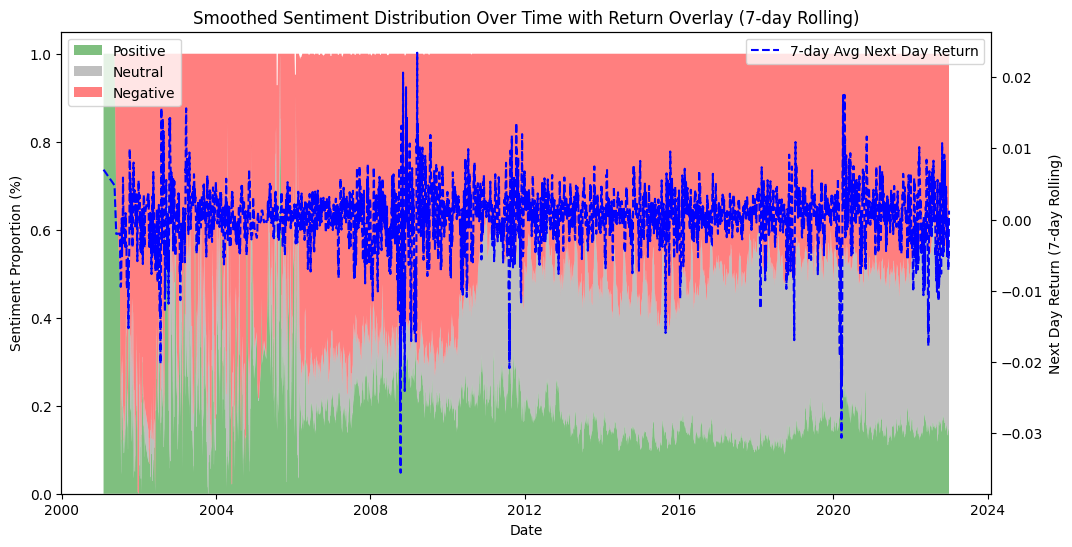

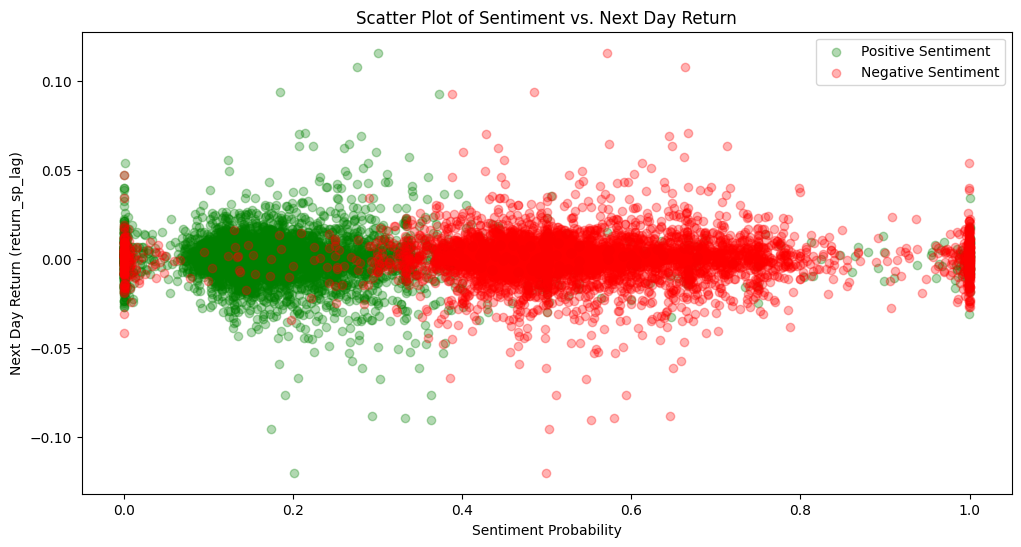

In [8]:
df_smoothed = df.copy()
df_smoothed["Positive_Prob"] = df["Positive_Prob"].rolling(window=7, min_periods=1).mean()
df_smoothed["Neutral_Prob"] = df["Neutral_Prob"].rolling(window=7, min_periods=1).mean()
df_smoothed["Negative_Prob"] = df["Negative_Prob"].rolling(window=7, min_periods=1).mean()
df_smoothed["return_sp_lag"] = df["return_sp_lag"].rolling(window=7, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.stackplot(
    df_smoothed["Date"],
    df_smoothed["Positive_Prob"],
    df_smoothed["Neutral_Prob"],
    df_smoothed["Negative_Prob"],
    labels=["Positive", "Neutral", "Negative"],
    colors=["green", "gray", "red"],
    alpha=0.5
)
ax1.set_ylabel("Sentiment Proportion (%)")
ax1.set_xlabel("Date")
ax1.set_title("Smoothed Sentiment Distribution Over Time with Return Overlay (7-day Rolling)")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(df_smoothed["Date"], df_smoothed["return_sp_lag"], color="blue", linestyle="dashed", label="7-day Avg Next Day Return")
ax2.set_ylabel("Next Day Return (7-day Rolling)")
ax2.legend(loc="upper right")

plt.show()


plt.figure(figsize=(12, 6))
plt.scatter(df["Positive_Prob"], df["return_sp_lag"], alpha=0.3, label="Positive Sentiment", color="green")
# plt.scatter(df["Neutral_Prob"], df["return_sp_lag"], alpha=0.3, label="Neutral Sentiment", color="gray")
plt.scatter(df["Negative_Prob"], df["return_sp_lag"], alpha=0.3, label="Negative Sentiment", color="red")
plt.xlabel("Sentiment Probability")
plt.ylabel("Next Day Return (return_sp_lag)")
plt.title("Scatter Plot of Sentiment vs. Next Day Return")
plt.legend()
plt.show()

In [9]:
df

,Date,Positive_Prob,Neutral_Prob,Negative_Prob,return_sp_lag,Positive_Prob_3d_avg,Neutral_Prob_3d_avg,Negative_Prob_3d_avg,Positive_Prob_7d_avg,Neutral_Prob_7d_avg,...,Negative_Prob_lag3,Positive_Prob_lag5,Neutral_Prob_lag5,Negative_Prob_lag5,Positive_Prob_lag10,Neutral_Prob_lag10,Negative_Prob_lag10,Positive_Prob_lag14,Neutral_Prob_lag14,Negative_Prob_lag14
0,2001-01-31,0.999995,6.572483e-07,0.000004,0.007008,0.999995,6.572483e-07,0.000004,0.999995,6.572483e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001-05-15,0.999943,1.623484e-06,0.000055,0.002609,0.999969,1.140366e-06,0.000030,0.999969,1.140366e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001-05-31,0.000015,1.336834e-06,0.999984,-0.015656,0.666651,1.205855e-06,0.333348,0.666651,1.205855e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-07-05,0.000036,1.841972e-06,0.999962,-0.001836,0.333331,1.600763e-06,0.666667,0.499997,1.364884e-06,...,0.000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001-07-06,0.000009,8.774749e-07,0.999990,-0.012321,0.000020,1.352094e-06,0.999978,0.400000,1.267403e-06,...,0.000055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7227,2022-12-23,0.149612,4.273027e-01,0.423085,-0.014452,0.140051,4.307414e-01,0.429207,0.156887,4.116867e-01,...,0.443928,0.174265,0.438822,0.386912,0.101410,0.426214,0.472376,0.155466,0.433787,0.410746
7231,2022-12-27,0.162951,3.832634e-01,0.453785,0.005868,0.121328,4.043728e-01,0.474299,0.122255,4.188616e-01,...,0.501663,0.168006,0.365973,0.466021,0.203548,0.395650,0.400802,0.101410,0.426214,0.472376
7232,2022-12-28,0.158755,3.961565e-01,0.445089,-0.004050,0.148159,4.124506e-01,0.439390,0.130287,4.041770e-01,...,0.549815,0.149612,0.427303,0.423085,0.174265,0.438822,0.386912,0.121337,0.448038,0.430625
7233,2022-12-29,0.114108,4.130679e-01,0.472824,-0.012021,0.145272,3.974960e-01,0.457232,0.122587,4.109049e-01,...,0.419296,0.071649,0.426689,0.501663,0.156264,0.343017,0.500719,0.148786,0.367616,0.483598


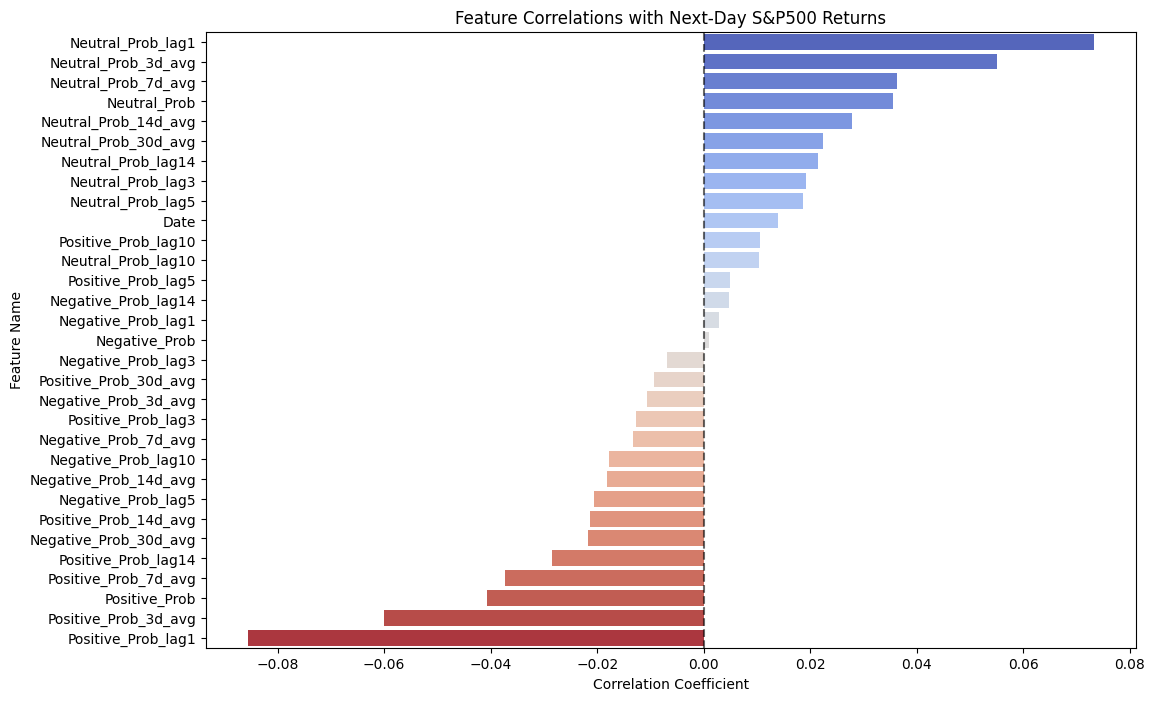

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = df.corr()

# Focus on correlations with return_sp_lag
corr_target = corr_matrix["return_sp_lag"].sort_values(ascending=False)

# Plot as a horizontal bar chart for better readability
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_target.values[1:], y=corr_target.index[1:], palette="coolwarm")
plt.axvline(x=0, color="black", linestyle="dashed", alpha=0.6)  # Add reference line at 0
plt.title("Feature Correlations with Next-Day S&P500 Returns")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature Name")
plt.show()


In [11]:
corr_target

,return_sp_lag
return_sp_lag,1.000000
Neutral_Prob_lag1,0.073226
Neutral_Prob_3d_avg,0.054984
Neutral_Prob_7d_avg,0.036288
Neutral_Prob,0.035545
Neutral_Prob_14d_avg,0.027916
Neutral_Prob_30d_avg,0.022391
Neutral_Prob_lag14,0.021432
Neutral_Prob_lag3,0.019276
Neutral_Prob_lag5,0.018571


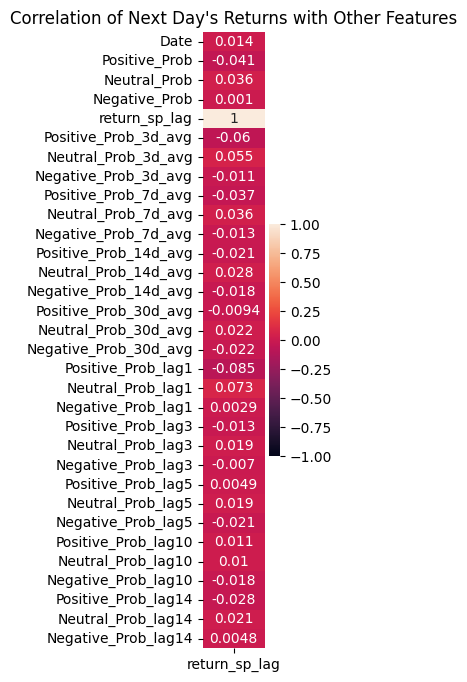

In [12]:
plt.figure(figsize=(1,8))
sns.heatmap(df.corr()[['return_sp_lag']], annot=True, vmin=-1, vmax=1)
plt.title("Correlation of Next Day's Returns with Other Features")
plt.show()

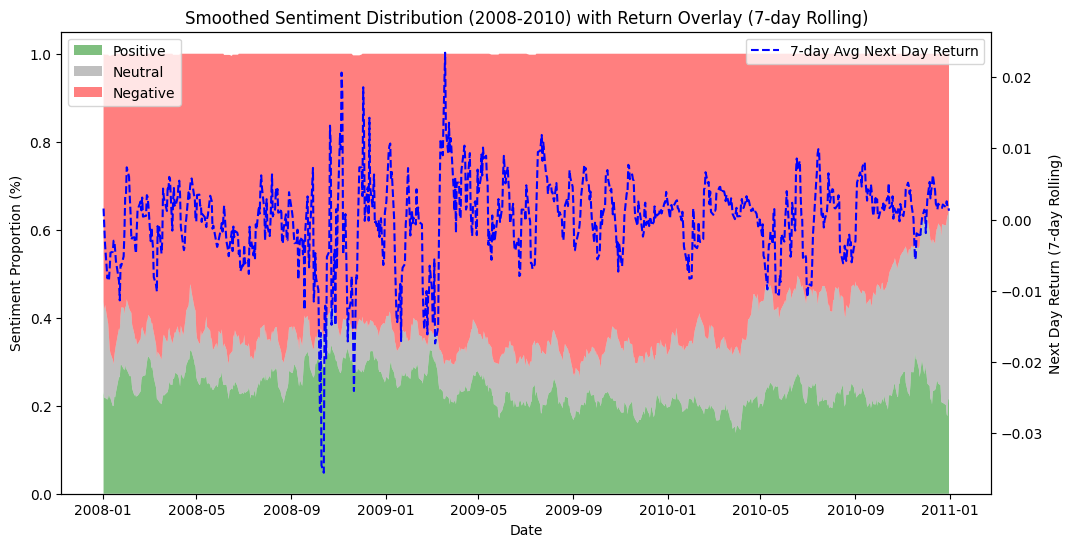

In [13]:
# Filter a particular time frame
df_filtered = df_smoothed[(df_smoothed["Date"] >= "2008-01-01") & (df_smoothed["Date"] <= "2010-12-31")]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.stackplot(
    df_filtered["Date"],
    df_filtered["Positive_Prob"],
    df_filtered["Neutral_Prob"],
    df_filtered["Negative_Prob"],
    labels=["Positive", "Neutral", "Negative"],
    colors=["green", "gray", "red"],
    alpha=0.5
)
ax1.set_ylabel("Sentiment Proportion (%)")
ax1.set_xlabel("Date")
ax1.set_title("Smoothed Sentiment Distribution (2008-2010) with Return Overlay (7-day Rolling)")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(df_filtered["Date"], df_filtered["return_sp_lag"], color="blue", linestyle="dashed", label="7-day Avg Next Day Return")
ax2.set_ylabel("Next Day Return (7-day Rolling)")
ax2.legend(loc="upper right")

plt.show()


In [14]:
def backtest_sentiment_strategy(df, initial_capital=1000):
    """
    Backtests a sentiment-based trading strategy where:
    - A buy signal occurs when Positive_Prob > Negative_Prob.
    - A sell signal occurs when Negative_Prob > Positive_Prob.
    - Portfolio starts with `initial_capital` and reinvests all cash upon a buy.
    - Returns are applied when holding a position.
    - Exits convert holdings back to cash.

    Parameters:
    df: Contains sentiment probabilities and market returns.
    initial_capital (int, optional): Starting capital for the strategy. Defaults to 1000.

    Returns:
    df: Updated with Portfolio_Value and Buy_Hold_Value.
    """

    df = df.copy()
    df["return_sp_lag"].fillna(0, inplace=True)

    # Compute trading signals
    df["Signal"] = np.where(df["Positive_Prob"] > df["Negative_Prob"], 1, 0)
    df["Exit"] = np.where(df["Negative_Prob"] > df["Positive_Prob"], 1, 0)

    # Initialize portfolio variables
    df["Portfolio_Value"] = initial_capital
    holding = False
    cash = initial_capital  # Start with full cash
    position = 0  # No initial holdings
    portfolio_values = []

    # Iterate through the dataset
    for i in range(len(df)):
        if df["Signal"].iloc[i] == 1 and not holding:  # Buy if signal is triggered and not already holding
            position = cash  # Invest all cash
            cash = 0  # No cash left
            holding = True  # Now holding a position

        elif df["Exit"].iloc[i] == 1 and holding:  # Sell if exit condition is met
            cash = position  # Convert position back to cash
            position = 0  # No market exposure
            holding = False  # No longer holding

        if holding:
            position *= (1 + df["return_sp_lag"].iloc[i])

        portfolio_values.append(position + cash)

    df["Portfolio_Value"] = portfolio_values
    df["Buy_Hold_Value"] = initial_capital * (1 + df["return_sp_lag"]).cumprod()

    # plot backtesting comparisons
    plt.figure(figsize=(7, 7))
    plt.plot(df["Date"], df["Portfolio_Value"], label="Sentiment-Based Strategy", color="blue", linewidth=2)
    plt.plot(df["Date"], df["Buy_Hold_Value"], label="Buy and Hold", color="green", linestyle="dashed", linewidth=2)
    plt.axhline(initial_capital, color="black", linestyle="dotted", alpha=0.6)
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.title("Backtest: Sentiment-Based Strategy vs. Buy and Hold")
    plt.legend()
    plt.show()

    total_trades = df["Signal"].sum()
    exit_trades = df["Exit"].sum()
    print(f"Total Buy Signals: {total_trades}")
    print(f"Total Exit Signals: {exit_trades}")

    return df


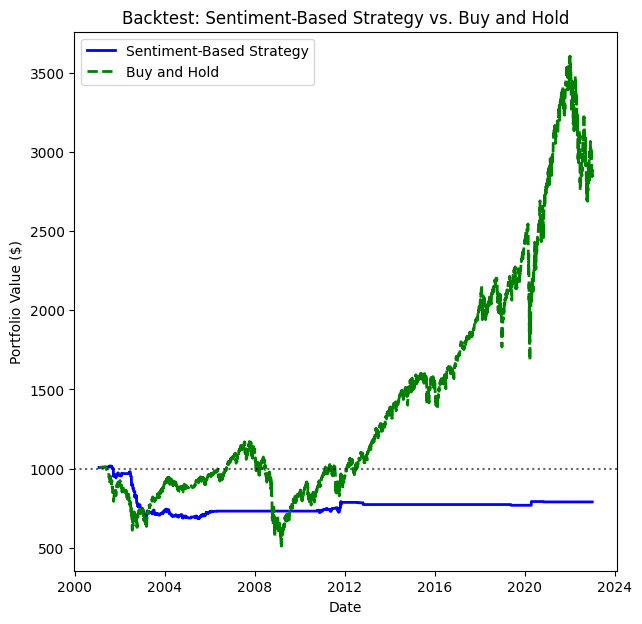

Total Buy Signals: 284
Total Exit Signals: 4906


In [15]:
backtest = backtest_sentiment_strategy(df)

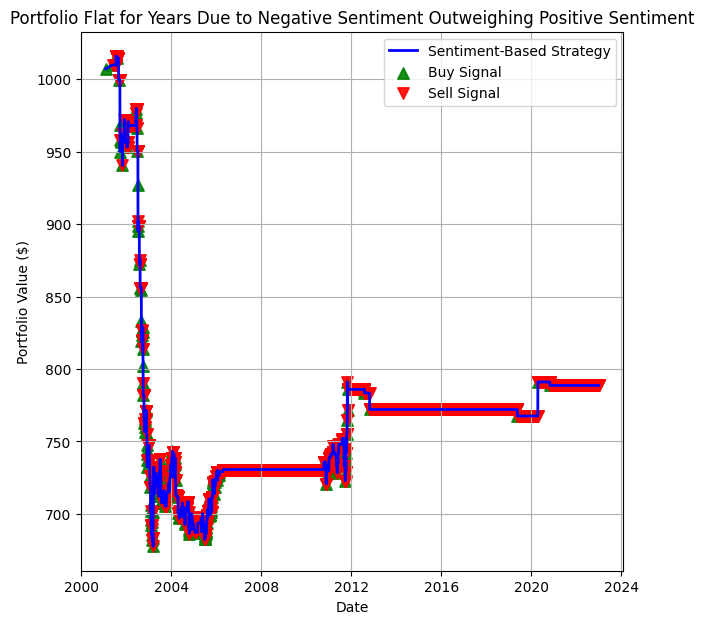

In [16]:
plt.figure(figsize=(7, 7))

plt.plot(backtest["Date"], backtest["Portfolio_Value"], label="Sentiment-Based Strategy", color="blue", linewidth=2)

buy_signals = backtest[backtest["Signal"] == 1]
sell_signals = backtest[backtest["Exit"] == 1]

plt.scatter(
    buy_signals["Date"], buy_signals["Portfolio_Value"],
    marker="^", color="green", label="Buy Signal",
    s=65, linewidth=1.2, alpha=0.9
)

plt.scatter(
    sell_signals["Date"], sell_signals["Portfolio_Value"],
    marker="v", color="red", label="Sell Signal",
    s=65, linewidth=1.2, alpha=0.9
)

plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Flat for Years Due to Negative Sentiment Outweighing Positive Sentiment")
plt.legend()
plt.grid(True)
plt.show()

### Random Forest Regressor

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Shift target by 1 day (Next day's return)
df['return_sp_lag'] = df['return_sp_lag'].shift(-1)  # Shift upwards for next day prediction

# Drop rows with NaN values (due to shifting)
df = df.dropna(subset=['return_sp_lag'])
df = df.dropna()

# Features: select the relevant features
features = [
    'Positive_Prob', 'Neutral_Prob', 'Negative_Prob',
    'Positive_Prob_3d_avg', 'Neutral_Prob_3d_avg', 'Negative_Prob_3d_avg',
    'Positive_Prob_7d_avg', 'Neutral_Prob_7d_avg', 'Negative_Prob_7d_avg',
    'Positive_Prob_lag1', 'Neutral_Prob_lag1', 'Negative_Prob_lag1'  # Include the 1-day lag
]

# Target
target = 'return_sp_lag'

# Train-test split
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [27]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Feature importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))


Mean Squared Error: 0.00013869698834717683
R-squared: -0.039229211555110055
                 Feature  Importance
9     Positive_Prob_lag1    0.099067
0          Positive_Prob    0.098551
7    Neutral_Prob_7d_avg    0.091943
1           Neutral_Prob    0.086775
6   Positive_Prob_7d_avg    0.085530
3   Positive_Prob_3d_avg    0.083443
2          Negative_Prob    0.082807
10     Neutral_Prob_lag1    0.080371
8   Negative_Prob_7d_avg    0.075086
11    Negative_Prob_lag1    0.072919
4    Neutral_Prob_3d_avg    0.072629
5   Negative_Prob_3d_avg    0.070877


Interpreting the Output
The feature importance values tell you how much each feature contributes to the model's predictions. Higher values indicate that a feature has a larger impact on the prediction of the target variable, while lower values suggest less influence.

In this case, the most important features are:

Positive_Prob (Importance: 0.141): This is the single most important feature, meaning that the positive sentiment in the dataset plays the largest role in predicting the next day's returns.
Neutral_Prob_7d_avg (Importance: 0.094): The 7-day rolling average of neutral sentiment is also significant, indicating that recent neutral sentiment trends are relevant.
Neutral_Prob_lag1 (Importance: 0.093): The sentiment from one day ago for neutral probability is important, suggesting that short-term neutral sentiment influences next-day returns.
Other notable features:

Positive_Prob_7d_avg and Positive_Prob_lag1 are also relatively important, which implies that short-term and lagged positive sentiment impacts market returns.
Negative_Prob_7d_avg and Negative_Prob_lag1 have lower importance, which may suggest that negative sentiment, while still relevant, is less impactful in this dataset.
Key Takeaways from the Feature Importance:
Positive sentiment seems to play a bigger role than negative sentiment in predicting returns.
Short-term trends (3-day and 7-day averages) and lagged sentiment (one-day lags) are quite important. This suggests that momentum in sentiment (especially neutral and positive sentiment) over recent days has a significant impact on the target.

### Sentiment Analysis (NN)

In [28]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Using BERT Embeddings in NN

In [29]:
# Defining NN

import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class SentimentNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First hidden layer
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the model
input_dim = X_train.shape[1]  # Number of features
hidden_dim = 128  # You can tweak this
output_dim = 1  # We're predicting a single value (return_sp_lag)

model = SentimentNN(input_dim, hidden_dim, output_dim)


In [30]:
# Training NN
# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Convert training data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Regression problem, so use MSELoss

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0004
Epoch [20/100], Loss: 0.0002
Epoch [30/100], Loss: 0.0002
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0002
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0002


In [31]:
# Eval Model
model.eval()
with torch.no_grad():
    # Predictions on the test set
    y_test_pred = model(X_test_tensor)
    test_loss = criterion(y_test_pred, y_test_tensor)

    print(f'Test Loss (MSE): {test_loss.item():.4f}')

    # You can also calculate R-squared or other metrics
    y_test_pred_numpy = y_test_pred.cpu().numpy()
    y_test_numpy = y_test_tensor.cpu().numpy()

    from sklearn.metrics import r2_score
    r2 = r2_score(y_test_numpy, y_test_pred_numpy)
    print(f'R-squared: {r2:.4f}')


Test Loss (MSE): 0.0001
R-squared: -0.0769
